In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle

import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    

import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### First, load in the unmasked coordinates

In [2]:
%%time
var = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'] # get the unmasked coordinates for plotting later on
for f in range(4):
    ds = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc')[var[f]] # get the dataset structure
    ds.values = xr.open_mfdataset('/g/data/ik11/grids/ocean_grid_01.nc')[var[f]].values # feed in the unmasked data into the dataset structure
    if f == 0: geolon_t = ds
    if f == 1: geolat_t = ds
    if f == 2: geolon_c = ds
    if f == 3: geolat_c = ds # I need the xarray.DataArray 'geolon_t' (yt_ocean: 2700xt_ocean: 3600) structure for later on calculating the make_boundary_path() function

CPU times: user 3.56 s, sys: 2.34 s, total: 5.9 s
Wall time: 18.7 s


### JRA55-do: Create monthly anomaly fields for all input variables

In [3]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
# --- which forcing to use, either JRA55-do-1-3, JRA55-do-1-4-0 or JRA55-do-1-5-0                              #
forcing = '1-3' # 1-4-0                                                                                        #
period = ['1958','2018'] # which period to consider for anomaly calculation                                    #
version = 'v20180412' #'v20190429'                                                                             #
short = 'gn' # 'gr'                                                                                            #
# ------------------------------------------------------------------------------------------------------------ #
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
out = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'
var = ['huss','psl','tas','ts', 'uas','vas','prra','prsn','rlds','rsds','friver','tos','taux', 'tauy'] # only eight of the variables I used in my Msc

for i in range(len(var)-2): # loop through all variables
    if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']
    if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
    if var[i] in ['friver', 'tos']:                     domain = 'ocean/day/';   timestep = ['0101','1231']
    print(domain+var[i]); print('--- --- --- --- ---')

    # filenames for output files
    f1 = out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[i]+'_monthly_mean_'+period[0]+'-'+period[1]+'_detrend.nc'
    f2 = out + 'monthly_anom/JRA55-do-'+forcing+'_'+var[i]+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    if os.path.isfile(f2) == True: # skip iteration if final .nc file already exists
        continue       

# Step I: merge files, create monthly mean fields and detrend
    cdo.detrend(input = '-monmean -mergetime ' + base + domain + var[i] + '/'+short+'/'+version+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '_'+short+'_{' + period[0] + '..' + period[1] + '}*',
                output = f1, force=False)
    # Walltime: 22min 16s for one variable

# Step II: create monthly anomalies
    field = xr.open_dataset(f1)
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[i]].drop('month').to_netcdf(f2) # save as netcdf file

# Step II: create monthly mean and remove that to get the anomalies
#     field = xr.open_dataset(f1)
#     anom = field.groupby('time.month') - field.groupby('time.month').mean('time')
#     anom.to_netcdf(f2) # Wall time: 42.5 s for one field
#     cdo.yseassub(input = f1 +' -yseasavg -selyear,1958/1988 ' + f1, output = f2, force=False)
    
# Step II: also calculating wind stresses
rho_a = 1.25 # kg m$^{-3}$ reference air density at sea level
C_D = 1.5e-3 # unitless drag coefficient (Kara et al. 2007)
uas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[4]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').uas
vas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[5]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').vas

print('atmos/3hrPt/taux'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*uas).to_dataset(name='taux').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_taux_monthly_mean_'+period[0]+'-'+period[1]+'.nc')
print('atmos/3hrPt/tauy'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*vas).to_dataset(name='tauy').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_tauy_monthly_mean_'+period[0]+'-'+period[1]+'.nc')

# also detrend the wind stress fields and create anomalies
for s in range(2):
    if s == 0: letter = 'x'
    if s == 1: letter = 'y'
    tau1 = out+'monthly_mean/JRA55-do-'+forcing+'_tau'+letter+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
    tau2 = out+'monthly_anom/JRA55-do-'+forcing+'_tau'+letter+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    cdo.detrend(input=tau1, output = tau1.replace('.nc','_detrend.nc'), force=False)
    field = xr.open_dataset(tau1.replace('.nc','_detrend.nc'))              # selecting taux or tauy variable
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[s+12]].drop('month').to_netcdf(tau2) # save as netcdf file

# Total Walltime for all 11 vars: 4h 3min 56s
# Wall time: 1min 56s when files already exist

atmos/3hrPt/huss
--- --- --- --- ---
atmos/3hrPt/psl
--- --- --- --- ---
atmos/3hrPt/tas
--- --- --- --- ---
atmos/3hrPt/ts
--- --- --- --- ---
atmos/3hrPt/uas
--- --- --- --- ---
atmos/3hrPt/vas
--- --- --- --- ---
atmos/3hr/prra
--- --- --- --- ---
atmos/3hr/prsn
--- --- --- --- ---
atmos/3hr/rlds
--- --- --- --- ---
atmos/3hr/rsds
--- --- --- --- ---
ocean/day/friver
--- --- --- --- ---
ocean/day/tos
--- --- --- --- ---
atmos/3hrPt/taux
--- --- --- --- ---
atmos/3hrPt/tauy
--- --- --- --- ---
CPU times: user 1min 49s, sys: 18 s, total: 2min 7s
Wall time: 1min 53s


### Calculating the N34 index and the idealised N34 polynomial

CPU times: user 51.8 s, sys: 3.04 s, total: 54.8 s
Wall time: 47.8 s


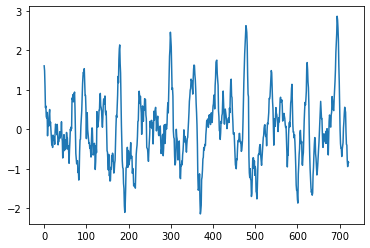

In [4]:
%%time
f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
# remove monthly mean to calculate anomalies
ts = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time')) 
N34_JRA = ts.isel(lon = slice(339,428)).isel(lat = slice(150,169)).mean(['lat','lon']).load() # N34 region: 5°S-5°N and 170°W-120°W -> -5.335°S ... 5.335°S, 190.1°E ... 240.2°E

# N3_JRA  = ts.isel(lat=slice(150,170)).isel(lon = slice(374,481)).mean(['lat','lon']).load() # N3  region: 5°S-5°N and 150°W-90°W
# N4_JRA  = ts.isel(lat=slice(150,170)).isel(lon = slice(285,375)).mean(['lat','lon']).load() # N4  region: 5°S-5°N and 160°E-150°W
plt.plot(N34_JRA) 
# Wall time: 44.3 s

### Calculating the SAM index and showing the index as composites during strong ENSO events

In [5]:
%%time
psl = xr.open_dataset(f11 + 'psl' + f22).psl#.groupby('time.month') - (xr.open_dataset(f11 + 'psl' + f22).psl.groupby('time.month').mean('time')) 
# Wall time: 43.3 s

CPU times: user 13.9 ms, sys: 2.66 ms, total: 16.5 ms
Wall time: 14.5 ms


Keppler, L., Landschützer, P. Regional Wind Variability Modulates the Southern Ocean Carbon Sink. Sci Rep 9, 7384 (2019). https://doi.org/10.1038/s41598-019-43826-y

The SAM index

We use the SAM index by Marshall et al.7, which is based on the observed pressure difference between six stations at 40°S and 65°S. We standardise the index by subtracting the mean and dividing it by the standard deviation over the time period (1958 to 2017), following Lovenduski et al.13. We then smooth the standardised index with a 3-month running mean in order to be able to analyse the inter-annual signal of the SAM, following Lenton and Matear12. Although some studies do not smooth the SAM index at all, others smooth with a running mean of 8 or 12 months12,13,14. We tested different high-pass and low-pass filters and found that the 3-month running mean can represent the inter-annual variability of the SAM index without removing too much of the signal.



Text(0.5, 1.0, 'With 3-month running window')

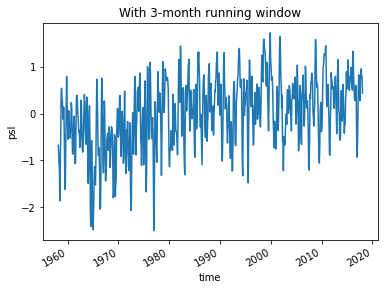

In [6]:
for f in range(2):
    if f == 0: l = 88 # select latitude 40.16°S
    if f == 1: l = 43 # select latitude 65.43°S
    SAM = psl.isel(lat = l).mean('lon') # select lat & take zonal mean
    
    if f == 0: SAM40 = SAM
    if f == 1: SAM65 = SAM
SAM = (SAM40 - SAM65) # take the difference
SAM = (SAM - SAM.mean('time')) / np.std(SAM) # remove the mean and standardise 
SAM_index = SAM.rolling(time=3, center=True).mean() # take three-month rolling/running mean
SAM_index.plot(); plt.title('With 3-month running window')

### Calculating the ASL index

In [7]:
%%time
# ------------------------------------------------------------------------------------------- #
sel_lat = [ 17, 80]  # [17,53] = 80°S-60°S, [17,80] = 80°S-45°S                               #
# sel_lon = [320, 535] # [320, 535] = 60°W to 180°W, [356, 535] = 60°W to 160°W               #
sel_lon = [427, 535] # [338,531] = 170°E-298°E=190°W-62°W, [374,535] = 210°E-300°E=150°W-60°W # [427,535] = 240°E-300°E=150°W-60°W #
# ------------------------------------------------------------------------------------------- #

# get land sea mask
tos = xr.open_mfdataset('/g/data/e14/mv7494/JRA55-do-1-3/land_sea_mask_320x640.nc').tos[0,:,:].fillna(0) # load in temperature at ocean surface and replace all nan with zeroes
landsea_mask = tos.where(tos>=0,1).where(tos<=0,1).where(tos != 0) # replace all non-zero data with ones


# psl = xr.open_dataset(f11 + 'psl' + f22).psl.groupby('time.month') - (xr.open_dataset(f11 + 'psl' + f22).psl.groupby('time.month').mean('time'))
f11 = out+'monthly_anom/JRA55-do-'+forcing+'_';
psl = xr.open_dataset(f11 + 'psl' + '_monthly_anom_'+period[0]+'-'+period[1]+'.nc').psl

ASL_JRA = (psl * landsea_mask)[:,sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]].mean(['lat', 'lon']).load()#.rolling(time=11, center=True).mean().load()

CPU times: user 1.03 s, sys: 1.05 s, total: 2.09 s
Wall time: 6.68 s


In [8]:
EN_periods = [168,192,288,312,467,491,683,707]
(psl/100 * landsea_mask)[EN_periods[6]+6:EN_periods[6]+18,0:82,427:535].mean(['time', 'lat', 'lon']).values

array(2.7057788, dtype=float32)

In [9]:
# quick check if spatial pattern is correct for the EN97/98 event

check = (psl/100 * landsea_mask)[EN_periods[4]+6:EN_periods[4]+18,0:82,:].mean(['time', 'lat', 'lon']).values
check
# Wall time: 36.4 s

array(-0.07561733, dtype=float32)

In [10]:
check = ((psl * landsea_mask)[EN_periods[0]+6:EN_periods[0]+18,0:82,:].mean('time') + (
    psl * landsea_mask)[EN_periods[2]+6:EN_periods[2]+18,0:82,:].mean('time') + (
    psl * landsea_mask)[EN_periods[4]+6:EN_periods[4]+18,0:82,:].mean('time') + (
    psl * landsea_mask)[EN_periods[6]+6:EN_periods[6]+18,0:82,:].mean('time')) / 4 / 100 # take the mean over all the four events and convert to hPa

### Quick check if all good with SLP anom calculations

Text(0.5, 1.0, 'Peak EN97/98 SLP anoms (Pa)')

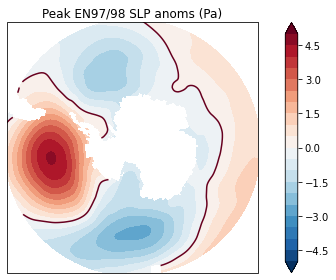

In [11]:
fig = plt.figure(figsize=(8,4),tight_layout=True,facecolor='w',edgecolor='k'); gs = gridspec.GridSpec(1,1) 

ax1  = plt.subplot(projection=ccrs.SouthPolarStereo(central_longitude=0)).set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
p1   = check.plot.contourf(ax=ax1, levels = np.linspace(-5,5,21), cmp='RdBu_r',add_colorbar=True,extend='both',transform=ccrs.PlateCarree())
p11  = check.plot.contour(ax=ax1, levels = [0], c='grey',transform=ccrs.PlateCarree())
plt.title('Peak EN97/98 SLP anoms (Pa)')

### The ASL index from Hosking et al. (2016) -> downloaded from the web

In [12]:
# /g/data/e14/mv7494 open csv
import pandas as pd

ds = pd.read_csv('/g/data/e14/mv7494/asli_era5_v3-latest.csv', usecols= ['time','lon','lat','ActCenPres','SectorPres','RelCenPres'], comment='#', skiprows=1)
ASL_time = ds['time'][:719]
ASL_time

0      1959-01-01
1      1959-02-01
2      1959-03-01
3      1959-04-01
4      1959-05-01
          ...    
714    2018-08-01
715    2018-09-01
716    2018-10-01
717    2018-11-01
718    2018-12-01
Name: time, Length: 719, dtype: object

In [13]:
ASL_SectorPres = ds['SectorPres'][:719].values

def hamming(ts):
    # Hamming window (normalise first so integral equals 1)
    hamm = np.hamming(11) / np.sum(np.hamming(11))
    filt = np.convolve(hamm, ts, mode='same')
    return filt
# applying the hamming filter and because the first and last entry of the smoothed time series are a magnitude smaller, I remove them
# ... then I plot from February 1959 to November 2017, i.e., 1959.08 to 2017.91
# ASL_SectorPres = hamming(ASL_SectorPres)[1:-2] # remove first and last entry from smoothed time series

def moving_average(a, n=11) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
ASL_SectorPres_11m = moving_average(ASL_SectorPres)


### Apply low pass filter
- Info on the web: https://swharden.com/blog/2020-09-23-signal-filtering-in-python/

(-600.0, 600.0)

<Figure size 1944x648 with 0 Axes>

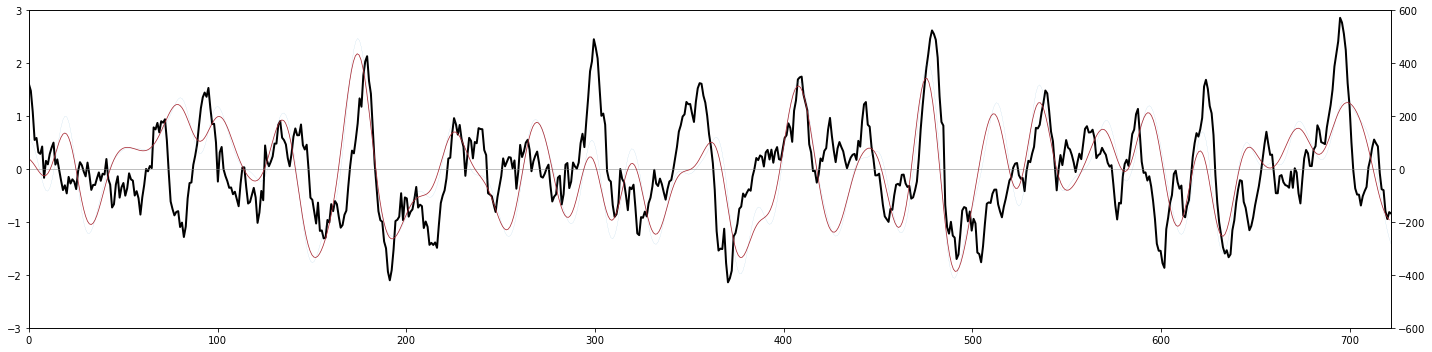

In [41]:
import scipy.signal 
b, a = scipy.signal.butter(3, 0.1) # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
filtered = scipy.signal.filtfilt(b, a, ASL_JRA, method="gust")
plt.figure(figsize=(27,9)); fig, ax1 = plt.subplots(figsize=(20,5),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,1); ax1 = plt.subplot(gs[0,0])

plt.plot(np.linspace(0, len(N34_JRA),len(N34_JRA)), N34_JRA, c='k', linewidth=2)

plt.axhline(0, linewidth=.5, c='grey'); plt.ylim([-3,3]); plt.xlim([0,722])
ax2 = ax1.twinx()
plt.plot(np.linspace(0, len(N34_JRA),len(N34_JRA)), ASL_JRA, c=rotblau[15], linewidth=.1)
plt.plot(filtered, c=rotblau[3], linewidth=.75); plt.ylim([-600,600])

### The correlation now
- function supplied by Christina Schmidt on the 31st of March 2023
- through slack
- also see https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(OpenStax)/12%3A_Linear_Regression_and_Correlation/12.05%3A_Testing_the_Significance_of_the_Correlation_Coefficient
- for information on the significance of the correlation

In [15]:
import scipy.signal as scipy_sig
import scipy.stats as scipy_stats
def correlation_3D(x, y, dims='time', return_p_value_text_Neff=False):
    # def detrend(da, dims):
    #     “”"Wrapper function for applying detrending and returning as DataArray”“”
    #     da_detrended = xr.DataArray(scipy_sig.detrend(
    #         da, axis=da.get_axis_num(dims)), dims=da.dims, coords=da.coords)
    #     return da_detrended
    # Detrend data
    # x = detrend(x, dims)
    # y = detrend(y, dims)
    # Compute covariance
    cov = (xr.dot(x - x.mean(dims), (y - y.mean(dims)).drop(dims), dims=dims) /
           x.count(dims))
    # Compute correlation along time axis
    cor = cov / (x.std(dims) * y.std(dims))
    # Compute effective degrees of freedom
    # calculate autocorrelation function
    xauto = xr.apply_ufunc(np.correlate, x, x, 'full',
                           input_core_dims=[[dims], [dims], []],
                           output_core_dims=[['lag']],
                           exclude_dims=set((dims,)),
                           vectorize=True) / (x.count(dims)*x.std(dims)**2)
    xauto = xauto.assign_coords(
        lag=np.arange(-x.count(dims).mean()+1, x.count(dims).mean()))
    yauto = xr.apply_ufunc(np.correlate, y, y, 'full',
                           input_core_dims=[[dims], [dims], []],
                           output_core_dims=[['lag']],
                           exclude_dims=set((dims,)),
                           vectorize=True) / (y.count(dims)*y.std(dims)**2)
    yauto = yauto.assign_coords(
        lag=np.arange(-y.count(dims).mean()+1, y.count(dims).mean()))
    # interpolate product of both autocorrelation functions
    # on time axis with higher resolution dt
    dt = 0.2
    new_axis = np.arange(-x.count(dims).mean()+1, x.count(dims).mean()-1+dt, dt)
    xauto_yauto_int = (xauto * yauto).interp(lag=new_axis)
    # calculate effective degrees of freedom
    ## index of lag 0
    tcen = int((len(new_axis)-1)/2)
    xauto_yauto_int_no_nan = xauto_yauto_int.isel(lag=slice(tcen, -1))
    xauto_yauto_int_no_nan = xauto_yauto_int_no_nan.where(
        np.isnan(xauto_yauto_int_no_nan) == False, 0)
    # timescale over which product of autocorrelation functions decays to 1/e
    Tx = (xauto_yauto_int_no_nan >= xauto_yauto_int_no_nan.isel(lag=0)/np.e).argmin('lag')
    N_eff = x.count(dims) / (2*dt*xauto_yauto_int.isel(lag=slice(tcen, None)).where(
        xr.DataArray(np.arange(tcen, tcen*2+1), dims='lag') <= (tcen+Tx)).sum(
        'lag', skipna=True))
    N_eff = N_eff.where(np.isinf(N_eff) == False)
    N_eff = N_eff.where((N_eff < x.count(dims).mean()) |
                        (np.isnan(N_eff) == True),
                        x.count(dims).mean())
    # Compute P-value using the students t test
    t_stat = cor*np.sqrt(N_eff)/(np.sqrt(1-cor*cor))
    p = (1.0 - scipy_stats.t.cdf(abs(t_stat), N_eff)) * 2.0
    p = xr.DataArray(p, dims=cor.dims, coords=cor.coords)
    if return_p_value_text_Neff == True:
        if p < 0.01:
            p_str = 'p<0.01'
        elif p < 0.05:
            p_str = 'p<0.05'
        else:
            p_str = 'not sign.'
        return cor, p, p_str, N_eff
    else:
        return cor, p
filtered_xr = ASL_JRA # copy-paste over structure of xarray file
filtered_xr.values = filtered
cor, pval = correlation_3D(N34_JRA, filtered_xr)
[cor.values, pval]

[array(0.45751742),
 <xarray.DataArray ()>
 array(1.09266835e-06)]

In [16]:
import numpy.ma as ma
a=ma.masked_invalid(N34_JRA); b=ma.masked_invalid(filtered)
msk = (~a.mask & ~b.mask)
print(ma.corrcoef(a[msk],b[msk]))

[[1.0 0.4575174107026004]
 [0.4575174107026004 1.0]]


In [17]:
import numpy.ma as ma
corr2 = np.round((ma.corrcoef(ma.masked_invalid(N34_JRA), ma.masked_invalid(filtered)))[0,1], 2)
corr2 # quick check, yes the correlation is the same

0.46

In [19]:
import numpy as np
from scipy import signal
import numpy.ma as ma

x = N34_JRA.values
y = ASL_JRA.values
correlation = signal.correlate(x - np.mean(x), y - np.mean(y), mode="full")
lags = signal.correlation_lags(len(x), len(y), mode="full")
lag = lags[np.argmax(abs(correlation))]

### Plotting routine for SAM index and ASL central pressure during ENSO events

In [20]:
%%time
# top four El Niño events
EN_periods = [168,192,288,312,467,491,683,707]
LN_periods = [168,216,347,395,468,516,612,660] # top four La Niña events

time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,24+22,24+24) # time axis of idealised time series

# top four El Niño events
SAM_1972 = SAM_index.isel(time = slice(EN_periods[0],EN_periods[1])).load() # N34 peak in 1972-12 (index 180)
SAM_1982 = SAM_index.isel(time = slice(EN_periods[2],EN_periods[3])).load() # N34 peak in 1982-12 (index 300)
SAM_1997 = SAM_index.isel(time = slice(EN_periods[4],EN_periods[5])).load() # N34 peak in 1997-11 (index 479)
SAM_2015 = SAM_index.isel(time = slice(EN_periods[6],EN_periods[7])).load() # N34 peak in 2015-12 (index 695)
# top four La Niña events
SAM_1973 = SAM_index.isel(time = slice(LN_periods[0],LN_periods[1])).load() # N34 peak in 1972-12 (index 192)
SAM_1988 = SAM_index.isel(time = slice(LN_periods[2],LN_periods[3])).load() # N34 peak in 1984-12 (index 370)
SAM_1998 = SAM_index.isel(time = slice(LN_periods[4],LN_periods[5])).load() # N34 peak in 1997-11 (index 491)
SAM_2011 = SAM_index.isel(time = slice(LN_periods[6],LN_periods[7])).load() # N34 peak in 2015-12 (index 634)

# now the same for the smoothed ASL index
# top four El Niño events
ASL_1972 = ASL_SectorPres_11m[EN_periods[0]-12:EN_periods[1]-12]
ASL_1982 = ASL_SectorPres_11m[EN_periods[2]-12:EN_periods[3]-12]
ASL_1997 = ASL_SectorPres_11m[EN_periods[4]-12:EN_periods[5]-12]
ASL_2015 = ASL_SectorPres_11m[EN_periods[6]-12:EN_periods[7]-12]
# top four La Niña events
ASL_1973 = ASL_SectorPres_11m[LN_periods[0]-12:LN_periods[1]-12]
ASL_1988 = ASL_SectorPres_11m[LN_periods[2]-12:LN_periods[3]-12]
ASL_1998 = ASL_SectorPres_11m[LN_periods[4]-12:LN_periods[5]-12]
ASL_2011 = ASL_SectorPres_11m[LN_periods[6]-12:LN_periods[7]-12]

CPU times: user 5.43 ms, sys: 1.7 ms, total: 7.12 ms
Wall time: 5.92 ms


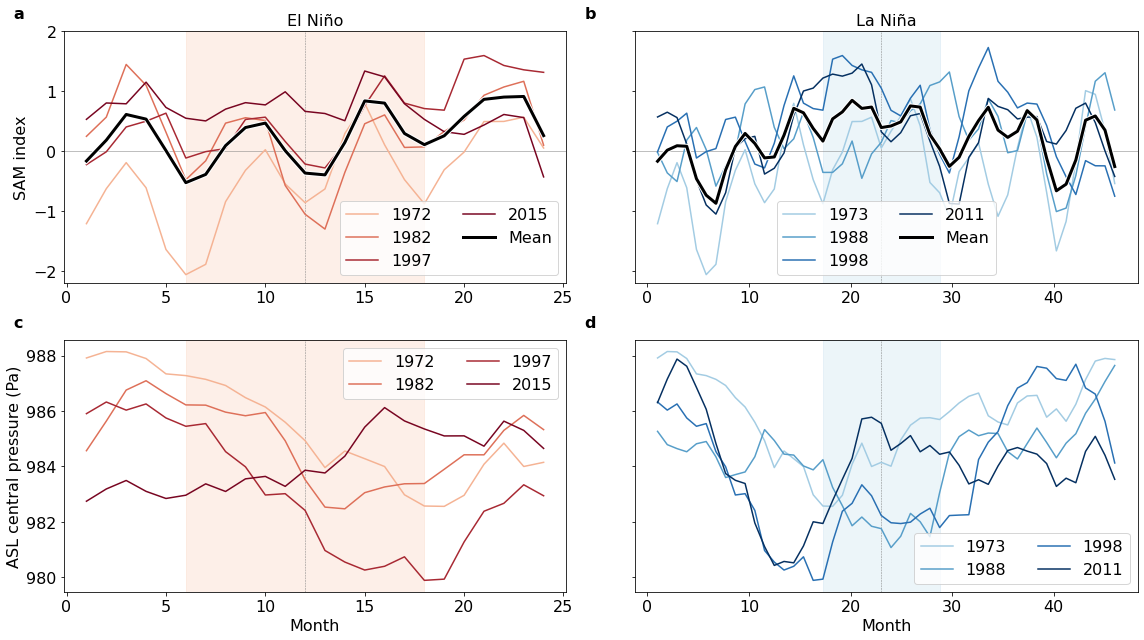

In [21]:
# initialise figure
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1]) 
event = ['El Niño', 'La Niña']
       
# ---------------------------- subplot 1 ---------------------------- #
for f in range(4):
    if f == 0:
        ax1 = plt.subplot(gs[0,0]); plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time, SAM_1972, color=rotblau[7], label='1972')
        plt.plot(time, SAM_1982, color=rotblau[5], label='1982')
        plt.plot(time, SAM_1997, color=rotblau[3], label='1997')
        plt.plot(time, SAM_2015, color=rotblau[1], label='2015')
    if f == 1:
        ax1 = plt.subplot(gs[0,1]); plt.axvline(12+11, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time2, SAM_1973, color=rotblau[13], label='1973')
        plt.plot(time2, SAM_1988, color=rotblau[15], label='1988')
        plt.plot(time2, SAM_1998, color=rotblau[17], label='1998')
        plt.plot(time2, SAM_2011, color=rotblau[20], label='2011')
    if f == 2:
        ax1 = plt.subplot(gs[1,0]); plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
        plt.plot(time, ASL_1972, color=rotblau[7], label='1972')
        plt.plot(time, ASL_1982, color=rotblau[5], label='1982')
        plt.plot(time, ASL_1997, color=rotblau[3], label='1997')
        plt.plot(time, ASL_2015, color=rotblau[1], label='2015')
    if f == 3:
        ax1 = plt.subplot(gs[1,1]); plt.axvline(12+11, linestyle = '--', c = 'grey', linewidth=.5)
        plt.plot(time2, ASL_1973, color=rotblau[13], label='1973')
        plt.plot(time2, ASL_1988, color=rotblau[15], label='1988')
        plt.plot(time2, ASL_1998, color=rotblau[17], label='1998')
        plt.plot(time2, ASL_2011, color=rotblau[20], label='2011')   

    EN_mean = np.zeros(24); LN_mean = np.zeros(24+24)
    for i in range(24):
        EN_mean[i] = (SAM_1972[i]+SAM_1982[i]+SAM_1997[i]+SAM_2015[i])/4
    for i in range(24+24):
        LN_mean[i] = (SAM_1973[i]+SAM_1988[i]+SAM_1998[i]+SAM_2011[i])/4

    if f == 0:
        plt.plot(time, EN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time, EN_mean, label = 'Mean', c = 'k', linewidth=3)

        ax1.axvspan(time[5], time[17], color=rotblau[8], alpha=.3) # shade period July to June the following year
        plt.title(event[f], fontsize=16)
        ax1.text(-.1, 1.05, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
        ax1.set_ylabel('SAM index', fontsize=16)
    if f == 1:
        plt.plot(time2, LN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time2, LN_mean, label = 'Mean', c = 'k', linewidth=3)

        ax1.axvspan(time2[5+12], time2[17+12], color=rotblau[12], alpha=.3)
        plt.title(event[f], fontsize=16)
        ax1.text(-.1, 1.05, string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
        ax1.set_yticklabels([])   
    if f == 2:
        # plt.plot(time, EN_mean, c = 'w', linewidth=5) # white edgecolor
        # plt.plot(time, EN_mean, label = 'Mean', c = 'k', linewidth=3)

        ax1.axvspan(time[5], time[17], color=rotblau[8], alpha=.3) # shade period July to June the following year
        ax1.text(-.1, 1.05, string.ascii_lowercase[2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
        ax1.set_ylabel('ASL central pressure (Pa)', fontsize=16)
    if f == 3:
        # plt.plot(time2, LN_mean, c = 'w', linewidth=5) # white edgecolor
        # plt.plot(time2, LN_mean, label = 'Mean', c = 'k', linewidth=3)

        ax1.axvspan(time2[5+12], time2[17+12], color=rotblau[12], alpha=.3)
        ax1.text(-.1, 1.05, string.ascii_lowercase[3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
        ax1.set_yticklabels([]) 
        
    
    if f in [0,1]:    
        # set fontsizes and labels
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        # if f == 0: ax1.set_xticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
        plt.ylim([-2.2,2]); plt.locator_params(axis='y', nbins=6) # only 3 y-axis ticks
    if f in [2,3]:    
        # set fontsizes and labels
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax1.set_xlabel('Month', fontsize=16)
        # plt.ylim([-2.2,2]); plt.locator_params(axis='y', nbins=6) # only 3 y-axis ticks        
        
# --- saving as 300 dpi .PNG image in specified folder ------------- #
filename = 'SAM_and_ASL_index_during_strong_ENSO_events'
plt.savefig(save + filename, dpi=300, facecolor='w',                 #
            edgecolor='w', orientation='landscape', papertype=None,  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ # # Wall time: 6.36 s

In [22]:
ASL_SectorPres_11m[EN_periods[6]+12:EN_periods[7]+12]

array([983.48335545, 982.71797364, 982.41986455, 982.18583727,
       982.04151091, 982.95554182, 982.65313636, 982.61917273,
       982.82437   , 983.45731091, 983.28707455, 983.25880182,
       982.73991091, 982.69466091])

### Calculating the spatial SST map and the N34 index for a subplot on the right

CPU times: user 51.2 s, sys: 2.95 s, total: 54.1 s
Wall time: 47.2 s


Text(0.5, 1.0, 'N34 index = -1.33°C')

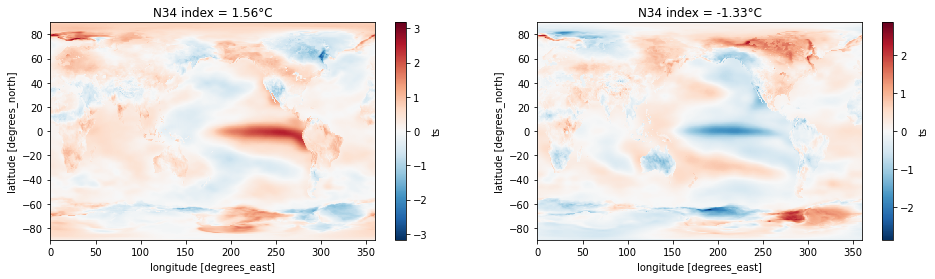

In [23]:
%%time
# top four El Niño events
EN_periods = [168,192,288,312,467,491,683,707]
LN_periods = [168,216,347,395,468,516,612,660] # top four La Niña events

f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
# remove monthly mean to calculate anomalies
anom = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time'))
# tos_mask = xr.open_dataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/ocean/day/tos/gn/v20180412/' + 
#                           'tos_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_19910101-19920101.nc').tos[0,:,:]
# tos_mask = tos_mask.fillna(0); tos_mask = tos_mask.where(tos_mask>=0,1).where(tos_mask<=0,1) # replace all NAN with zero and all non-zero data with ones

for f in range(2): # loop through the EN and LN events
    if f == 0: periode = EN_periods; shift = [6,18] # take specific events from the full time series
    if f == 1: periode = LN_periods; shift = [17,28]
    
    SST_map = ((anom[periode[0]+shift[0]:periode[0]+shift[1],:,:].mean('time') + anom[periode[2]+shift[0]:periode[2]+shift[1],:,:].mean('time') + \
        anom[periode[4]+shift[0]:periode[4]+shift[1],:,:].mean('time') + anom[periode[6]+shift[0]:periode[6]+shift[1],:,:].mean('time'))/4).load()
    N34_value = SST_map.isel(lon = slice(339,428)).isel(lat = slice(150,169)).mean(['lat','lon']).load()
    # N34_value = SST_map.sel(lon = slice(190,240)).sel(lat = slice(-5,5)).mean(['lat','lon']).load()
    
    # save data for each iteration
    if f == 0: SST_map_EN = SST_map; N34_value_EN = N34_value # multiply by land-sea mask so that the zero contours are only drawn over the ocean
    if f == 1: SST_map_LN = SST_map; N34_value_LN = N34_value # otherwise zero countours would have been over land as well as the data set is 
                                                                       # ts = temperature surface = combined ocean & land
plt.figure(figsize=(16,4))
plt.subplot(1,2,1); SST_map_EN.plot(); plt.title('N34 index = '+str(np.round(N34_value_EN.values,2))+'°C')
plt.subplot(1,2,2); SST_map_LN.plot(); plt.title('N34 index = '+str(np.round(N34_value_LN.values,2))+'°C')
# Walltime: 21.8 s

### Plotting routine

CPU times: user 30.8 s, sys: 5.51 s, total: 36.3 s
Wall time: 29.5 s


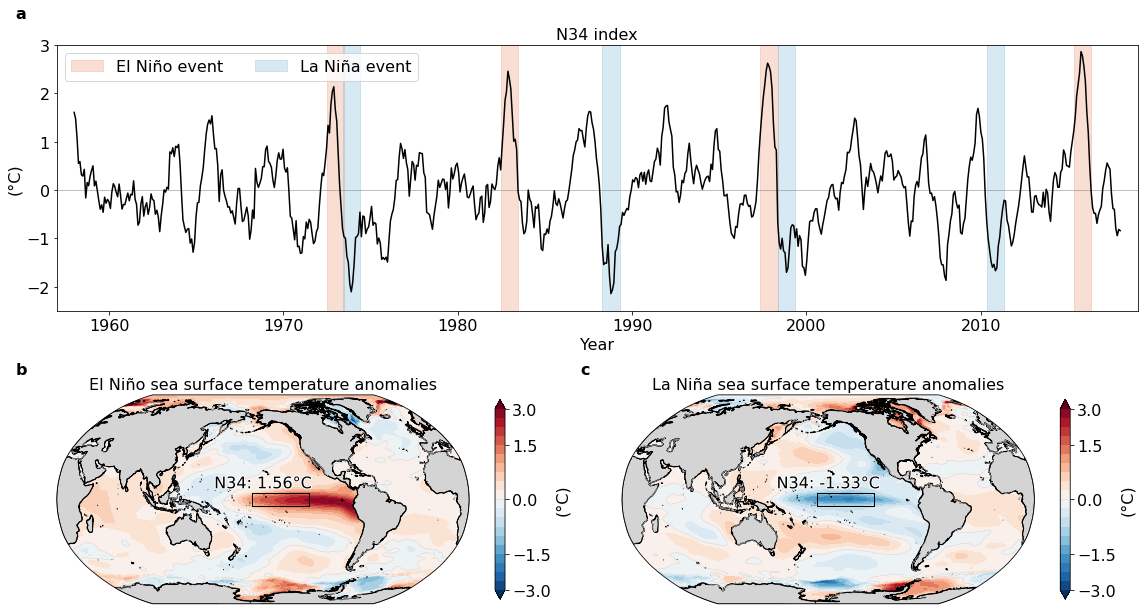

In [24]:
%%time
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k'); 
gs = gridspec.GridSpec(2,2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0,:]) # long first panel

time = np.linspace(1958,2018,len(N34_JRA)) # I cannot use the .time attribute from the xarray array as using it does not work with ax1.axvspan()

ax1.axhline(0, linewidth=.5, c='grey')

# colour the periods of strong EN & LN
EN_periods = [168,192,288,312,467,491,683,707]; LN_periods = [168,216,347,395,468,516,612,660]
# first doing the shading manually so that I can have figure labels
ax1.axvspan(time[EN_periods[0]+6], time[EN_periods[0]+18], color=rotblau[6], alpha=.3, label='El Niño event')
ax1.axvspan(time[LN_periods[0]+6+11], time[LN_periods[0]+18+11], color=rotblau[14], alpha=.3, label='La Niña event')
for f in [2,4,6]:
    ax1.axvspan(time[EN_periods[f]+6], time[EN_periods[f]+18], color=rotblau[6], alpha=.3)
    ax1.axvspan(time[LN_periods[f]+6+11], time[LN_periods[f]+18+11], color=rotblau[14], alpha=.3)

    
plt.plot(time, N34_JRA, c='k', linewidth=1.5) # plot the data
# plt.plot(time, N3_JRA, c=rotblau[3], label='N3$_\mathrm{{ (5°S-5°N, 150°W-90°W)}}$', linewidth=1.5) # plot the data
# plt.plot(time, N4_JRA, c=rotblau[17], label='N4$_\mathrm{{ (5°S-5°N, 160°E-150°W)}}$', linewidth=1.5) # plot the data
plt.title('N34 index', fontsize=16)

plt.legend(ncol=2,fontsize=16) # figure legend outside
plt.xlim([1957,2019]); plt.ylim([-2.5,3])
plt.ylabel('(°C)', fontsize=16); plt.xlabel('Year', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

ax1.text(-.038, 1.1,string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# second and third panels with SST map ---------------------------------------------- #
for f in range(2):
    if f == 0: panel = gs[1,0]; data = SST_map_EN; N34_value = N34_value_EN; title_str = 'El Niño'
    if f == 1: panel = gs[1,1]; data = SST_map_LN; N34_value = N34_value_LN; title_str = 'La Niña'
    
    ax1 = plt.subplot(panel, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    def fancy_plot(axes_nr):
        axes_nr.coastlines(resolution = '50m', linewidth=1) # add coast lines
        axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
        axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
    # ------------------------------------ #
    p1  = data.plot.contourf(ax=ax1, levels = np.linspace(-2.5,2.5,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = data.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree())
    # ------------------------------------ #                   #d4d4d4 = lightgrey = [.83, .83, .83] in HEX

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
    cb.set_label(label='(°C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar
    fancy_plot(ax1)

    # # drawing the N34 rectangle
    for r in range(4): # loop through the four sides of the rectangle
        if r == 0: lons = [-170,-120]; lats = [-5, -5] # bottom
        if r == 1: lons = [-170,-120]; lats = [5,   5] # top
        if r == 2: lons = [-170,-170]; lats = [-5,  5] # left
        if r == 3: lons = [-120,-120]; lats = [-5,  5] # right
        txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=1, transform=ccrs.PlateCarree(),)

    plt.title(title_str + ' sea surface temperature anomalies', size=16)
    txt = plt.text(-160, 12, 'N34: '+str(np.round(N34_value.values,2))+'°C', 
                   verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 16, horizontalalignment='center') # include N34 value in plot
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
    
    # if f == 0: # add tick labels for °N and °S                                                    # transparent color
    #     grd = ax1.gridlines(draw_labels=True, xlocs=[22,180,0], ylocs=[-60,-30,0,30,60], color='#FF000000')
    #     grd.top_labels = False
    #     grd.xlabel_style = {'size': 16}; grd.ylabel_style = {'size': 16}
 
    ax1.text(-.1, 1.1,string.ascii_lowercase[f+1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# --- saving as 300 dpi .PNG image in specified folder ------------- #
filename = 'N34_timeseries_and_spatial_mean_SST_maps_EN_LN'
plt.savefig(save + filename, dpi=300, facecolor='w',                 #
            edgecolor='w', orientation='landscape', papertype=None,  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ # # Wall time: 6.36 s

### Get the 1000 m isobath line and the mask with grid cells above 1000 m

CPU times: user 2.73 s, sys: 799 ms, total: 3.53 s
Wall time: 7.13 s


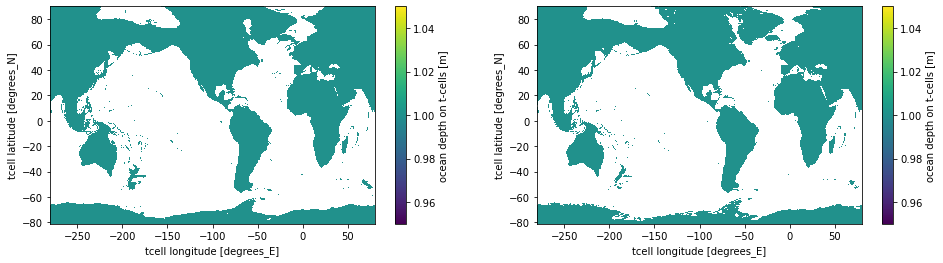

In [25]:
%%time
# topo = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/topog.nc').depth
# field = xr.open_mfdataset('/g/data/e14/mv7494/access-om2/archive/'+'025deg_jra55_ryf_ENControl'+'/output325/ocean/ocean.nc').temp[11,0,:,:]
# field.values = topo.values # write topography data into [yt_ocean, xt_ocean] array structure

# above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
# above1000_tcells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000
# # above1000_tcells.plot() # mask for all grid cells above 1000 dbar

# field = xr.open_mfdataset('/g/data/e14/mv7494/access-om2/archive/'+'025deg_jra55_ryf_ENControl'+'/output325/ocean/ocean_grid.nc').hu
# above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
# above1000_ucells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000
# # above1000_ucells.plot() # mask for all grid cells above 1000 dbar

field = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht
above1000_01 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_01_tcells = above1000_01.where(above1000_01 < 1000, drop=False) # remove all values bigger than 1000


field = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht
above500_01 = field.where(field >= 500,1) # set all values smaller than 500 to 1
above500_01_tcells = above500_01.where(above500_01 < 500, drop=False) # remove all values bigger than 500
plt.figure(figsize=(16,4)); plt.subplot(1,2,1); above1000_01_tcells.plot(); plt.subplot(1,2,2); above500_01_tcells.plot() 
# Wall time: 28.9 s

### Ok, next step is getting the temperature anomalies in the Amundsen Sea (1/10° model)

In [26]:
%%time
import warnings
warnings.filterwarnings('ignore')
base_omip = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle'
# -------------------------------------------------------------------------------------------------- #
depth      = [23,           47]                   # [23, 47] = 97.6 m - 1017 m                       #
# depth      = [27,           36]                 # [27, 36] = 150 m - 350 m                         #
# depth      = [24,           40]                 # [24, 40] = 108.9 m - 517.6 m                     #
depth_N34  = [               0]                   # 0 = sea surface                                  #
lat_N34    = [1194,       1296]                   # 5°S - 5°N                                        #
lon_N34    = [1099,       1600]                   # 170°W - 120°W                                    #
lat        = [0,           500]                   # 81.1°S - 59.5°S                                  #
lon        = [1299,       2200]                   # 150°W - 60°W                                     #
sel_lonABS = [1529, 1790, 2000]                   # [1529, 1790, 2000] = 127.1°W - 101.1°W - 80.05°W #
# -------------------------------------------------------------------------------------------------- #

import cosima_cookbook as cc
import os.path
from cosima_cookbook import explore
# db = '01deg_cycle4.db'
session = cc.database.create_session()
# directory_list=['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4']
# cc.database.build_index(directory_list, session)

for f in [1,2,3,4,5]:
    if f == 1:            experiment = '01deg_jra55v140_iaf'
    if f in [2,3,4]:      experiment = '01deg_jra55v140_iaf_cycle'+str(f)
    if f in [5]:          experiment = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'
    print('Loading in '+experiment)
    if f <= 4:
        temp = cc.querying.getvar(expt=experiment, variable='temp', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time='1958-01-31 00:00:00', 
                              end_time='2018-12-31 00:00:00')[0:len(N34_JRA), depth[0]:depth[1], lat[0]:lat[1], lon[0]:lon[1]].mean('st_ocean')
        temp = (temp*above1000_01_tcells) # select only on-shelf temperature values (100-1000 m)
        temp['time'] = N34_JRA.time # copy over same time indices as for the N34 index

    if f == 4: # if last cycle, also calculate the anomalies
        print('     also loading in the anomalies and regressed anomalies')
        climatology = (temp.groupby('time.month').mean('time'))
        anom =  (temp.groupby('time.month') - climatology).mean(['yt_ocean', 'xt_ocean']).load() # subtract the climatology to get the anomalies in °C 
        anom_regressed     =  (((temp.groupby('time.month') - climatology)*N34_JRA)/np.std(N34_JRA)).mean(['yt_ocean', 'xt_ocean']).load() # regress N34 onto the WA shelf temperature anomalies and take the mean      
        # anom_regressed_map =  (((temp.groupby('time.month') - climatology)*N34_JRA)/np.std(N34_JRA)).mean('time').load() # regress N34 onto the WA shelf temperature anomalies and take the mean      

    if f == 5:
        temp = cc.querying.getvar(expt=experiment, variable='temp', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time='2019-01-16 00:00:00', 
                              end_time='2022-03-16 00:00:00')[:, depth[0]:depth[1], lat[0]:lat[1], lon[0]:lon[1]].mean('st_ocean')
        temp = (temp*above1000_01_tcells) # select only on-shelf temperature values (100-1000 m)
        climatology = (temp.groupby('time.month').mean('time'))
        anom_ce =  (temp.groupby('time.month') - climatology) # subtract the climatology to get the anomalies in °C
        
        # calculate also N34 index
        temp_N34 = cc.querying.getvar(expt=experiment, variable='temp', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time='2019-01-16 00:00:00', 
                              end_time='2022-03-16 00:00:00')[:, 0, 1194:1296, 1099: 1600].mean(['yt_ocean', 'xt_ocean'])  # 5°S - 5°N, 170°W - 120°W 
        N34_ce =  (temp_N34.groupby('time.month') - (temp_N34.groupby('time.month').mean('time'))).load() # subtract the climatology to get the anomalies in °C 
        anom_ce_regressed =  ((temp.groupby('time.month') - climatology)*N34_ce).mean(['yt_ocean', 'xt_ocean']).load() # regress N34 onto the WA shelf temperature anomalies and take the mean

    temp = (temp - 273.15).mean(['yt_ocean', 'xt_ocean']).load() # convert to °C, take mean over latitude, longitude and load into MEM
    if f == 1: temp_cy1   = temp # save time series for each cycle
    if f == 2: temp_cy2   = temp
    if f == 3: temp_cy3   = temp
    if f == 4: temp_cy4   = temp; anom_cy4   = anom;    anom_cy4_regressed   = anom_regressed
    if f == 5: temp_cy4ex = temp; anom_cy4ex = anom_ce; anom_cy4ex_regressed = anom_ce_regressed
    print('----------------------------------------------')
# Wall time: 10min 19s

Loading in 01deg_jra55v140_iaf
----------------------------------------------
Loading in 01deg_jra55v140_iaf_cycle2
----------------------------------------------
Loading in 01deg_jra55v140_iaf_cycle3
----------------------------------------------
Loading in 01deg_jra55v140_iaf_cycle4
     also loading in the anomalies and regressed anomalies
----------------------------------------------
Loading in 01deg_jra55v140_iaf_cycle4_jra55v150_extension
----------------------------------------------
CPU times: user 16min 27s, sys: 39 s, total: 17min 6s
Wall time: 17min 29s


### Now also calculating the N34 subsurface temperature regression map for the last cycle

In [27]:
# %%time
# for f in [4]:
#     experiment = '01deg_jra55v140_iaf_cycle'+str(f)
#     print('Loading in '+experiment)
#     if f <= 4:
#         temp = cc.querying.getvar(expt=experiment, variable='temp', 
#                               session=session, frequency='1 monthly',
#                               attrs={'cell_methods': 'time: mean'},
#                               start_time='1958-01-31 00:00:00', 
#                               end_time='2018-12-31 00:00:00')[0:len(N34_JRA), depth[0]:depth[1], lat[0]:lat[1], :].mean('st_ocean')
#         temp = (temp*above1000_01_tcells) # select only on-shelf temperature values (100-1000 m)
#         temp['time'] = N34_JRA.time # copy over same time indices as for the N34 index

#     if f == 4: # if last cycle, also calculate the anomalies
#         climatology = (temp.groupby('time.month').mean('time'))
#         anom_regressed_map =  (((temp.groupby('time.month') - climatology)*N34_JRA)/np.std(N34_JRA)).mean('time').load() # regress N34 onto the WA shelf temperature anomalies and take the mean      
# anom_regressed_map.plot()
# # Wall time: 

CPU times: user 39.9 ms, sys: 21.5 ms, total: 61.4 ms
Wall time: 55.9 ms


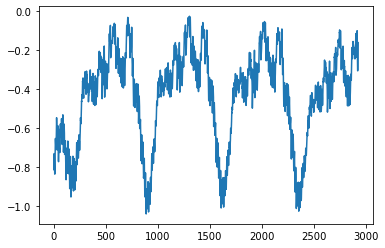

In [28]:
%%time
# combine all four cycles into one long time series
temp_all_cy = np.zeros(722*4+39)
temp_all_cy[0:722] = temp_cy1
temp_all_cy[722:722*2] = temp_cy2
temp_all_cy[722*2:722*3] = temp_cy3
temp_all_cy[722*3:722*4] = temp_cy4
temp_all_cy[722*4:] = temp_cy4ex
plt.plot(temp_all_cy)

# extend cycle 4 to 2022.25 (March of 2022)
temp4_ex           = np.zeros(722+39)
temp4_ex[0:722]    = temp_cy4
temp4_ex[722:]     = temp_cy4ex
anom_cy4_ex        = np.zeros(722+39)
anom_cy4_ex[0:722] = anom_cy4_regressed
anom_cy4_ex[722:]  = anom_cy4ex_regressed

N34_JRA_ex        = np.zeros(722+39)
N34_JRA_ex[0:722] = N34_JRA
N34_JRA_ex[722:]  = N34_ce

### Plotting routine

CPU times: user 1.38 s, sys: 148 ms, total: 1.53 s
Wall time: 1.27 s


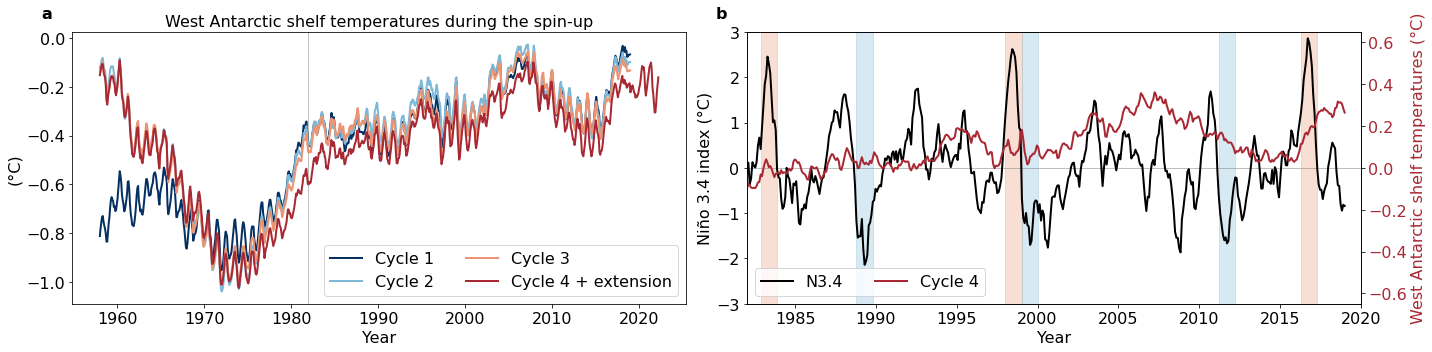

In [29]:
%%time
fig, ax1 = plt.subplots(figsize=(20,5),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,2); 

# ---------------------------------------------------------------------------------------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[0,0])
plt.axvline(1982, linewidth=.5, c='grey')

# time = np.linspace(0,722*4,722*4)
# plt.plot(time[0    :  722], temp_cy1, linewidth=2, c = rotblau[ 3], label = 'Cycle 1')
# plt.plot(time[722  :722*2], temp_cy2, linewidth=2, c = rotblau[ 6], label = 'Cycle 2')
# plt.plot(time[722*2:722*3], temp_cy3, linewidth=2, c = rotblau[14], label = 'Cycle 3')
# plt.plot(time[722*3:722*4], temp_cy4, linewidth=2, c = rotblau[20], label = 'Cycle 4'); plt.legend(fontsize=16)

time    = np.linspace(1958,2019,722)
time_ex = np.linspace(1958,2022.25,722+39)
plt.plot(time,  temp_cy1, linewidth=2, c = rotblau[20], label = 'Cycle 1')
plt.plot(time,  temp_cy2, linewidth=2, c = rotblau[14], label = 'Cycle 2')
plt.plot(time,  temp_cy3, linewidth=2, c = rotblau[ 6], label = 'Cycle 3')
plt.plot(time_ex,  temp4_ex, linewidth=2, c = rotblau[ 3], label = 'Cycle 4 + extension'); plt.legend(fontsize=16, ncol=2)

plt.title('West Antarctic shelf temperatures during the spin-up', fontsize=16)
plt.ylabel('(°C)', fontsize=16); plt.xlabel('Year', fontsize=16)
ax1.tick_params(axis='y', labelcolor='k'); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.text(-.05, 1.05, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# ---------------------------------------------------------------------------------------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[0,1])
plt.axhline(0, linewidth=.5, c='grey')
h1 = plt.plot(time, N34_JRA, c = 'k', linewidth=2, label='N3.4')
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylim([-3,3])

# colour the periods of strong EN & LN
EN_periods = [168,192,288,312,467,491,683,707]; LN_periods = [168,216,347,395,468,516,612,660]
# first doing the shading manually so that I can have figure labels
ax1.axvspan(time[EN_periods[0]+6], time[EN_periods[0]+18], color=rotblau[6], alpha=.3, label='El Niño event')
ax1.axvspan(time[LN_periods[0]+6+11], time[LN_periods[0]+18+11], color=rotblau[14], alpha=.3, label='La Niña event')
for f in [2,4,6]:
    ax1.axvspan(time[EN_periods[f]+6], time[EN_periods[f]+18], color=rotblau[6], alpha=.3)
    ax1.axvspan(time[LN_periods[f]+6+11], time[LN_periods[f]+18+11], color=rotblau[14], alpha=.3)
plt.ylabel('Niño 3.4 index (°C)', fontsize=16)
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax2.set_ylabel('(°C)', color=rotblau[3], fontsize=16)  # we already handled the x-label with ax1 

# h2 = plt.plot(time,  anom_cy4*N34_JRA, linewidth=2, c = rotblau[3], label = 'Cycle 4')
h2 = plt.plot(time,  anom_cy4,           linewidth=2, c = rotblau[3], label='Cycle 4') # anom regressed is the same as anom_cy4*N34_JRA
# h2 = plt.plot(time,  anom_cy4_regressed, linewidth=2, c = rotblau[3], label = 'Cycle 4') # anom regressed is the same as anom_cy4*N34_JRA

plt.xlim([1982,2020]); plt.ylim([-.65,.65])

# plt.title('Niño 3.4 index and regressed West Antarctic shelf temperature anomalies', fontsize=16)
plt.ylabel('West Antarctic shelf temperatures (°C)', fontsize=16); 
ax2.tick_params(axis='y', labelcolor=rotblau[3]); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

# adding legend of both axes
handles = h1 + h2
labs = [l.get_label() for l in handles]
ax1.legend(handles, labs, fontsize=16, ncol=2)
ax1.text(-.05, 1.05, string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# --- saving as 300 dpi .PNG image in specified folder --------------------------------------- #
plt.savefig(save + 'spin-up_time_series_all_cycles', dpi=300, facecolor='w',           #
            edgecolor='w', orientation='landscape', papertype=None,                            #
            format=None, transparent=False, bbox_inches='tight',                               #
            pad_inches=0.1, metadata=None)                                                     #
# --- end of script -------------------------------------------------------------------------- #
# Wall time: 1.98 s

### Get the idealised time series

In [30]:
time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,24+22,24+24) # time axis of idealised time series

# top four El Niño events
N34_1972 = N34_JRA.isel(time = slice(EN_periods[0],EN_periods[1])).load() / N34_value_EN # N34 peak in 1972-12 (index 180)
N34_1982 = N34_JRA.isel(time = slice(EN_periods[2],EN_periods[3])).load() / N34_value_EN # N34 peak in 1982-12 (index 300)
N34_1997 = N34_JRA.isel(time = slice(EN_periods[4],EN_periods[5])).load() / N34_value_EN # N34 peak in 1997-11 (index 479)
N34_2015 = N34_JRA.isel(time = slice(EN_periods[6],EN_periods[7])).load() / N34_value_EN # N34 peak in 2015-12 (index 695)
# top four La Niña events
N34_1973 = N34_JRA.isel(time = slice(LN_periods[0],LN_periods[1])).load() / (N34_value_LN*-1) # N34 peak in 1972-12 (index 192)
N34_1988 = N34_JRA.isel(time = slice(LN_periods[2],LN_periods[3])).load() / (N34_value_LN*-1) # N34 peak in 1984-12 (index 370)
N34_1998 = N34_JRA.isel(time = slice(LN_periods[4],LN_periods[5])).load() / (N34_value_LN*-1) # N34 peak in 1997-11 (index 491)
N34_2011 = N34_JRA.isel(time = slice(LN_periods[6],LN_periods[7])).load() / (N34_value_LN*-1) # N34 peak in 2015-12 (index 634)

### Plotting routine idealised time series and SLP + Wind spatial patterns

In [31]:
%%time
import matplotlib.path as mpath 
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)

CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 16.7 µs


CPU times: user 11.4 s, sys: 1.78 s, total: 13.2 s
Wall time: 11.5 s


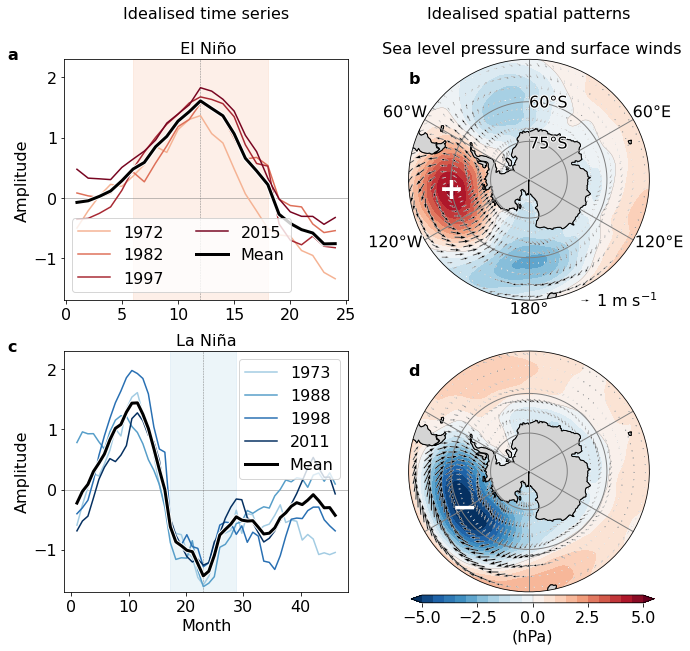

In [32]:
%%time
filename= 'Composite_N34_PC2_time_series_JRA_all_panels'
stand = 0
time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,24+22,24+24) # time axis of idealised time series
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(14,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1]) 
event = ['El Niño', 'La Niña']
       
# ---------------------------- subplot 1 ---------------------------- #
for f in [0,1,2,4]:
    if f == 0:
        ax1 = plt.subplot(gs[0,0]); plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time, N34_1972, color=rotblau[7], label='1972')
        plt.plot(time, N34_1982, color=rotblau[5], label='1982')
        plt.plot(time, N34_1997, color=rotblau[3], label='1997')
        plt.plot(time, N34_2015, color=rotblau[1], label='2015')
    if f == 1:
        ax1 = plt.subplot(gs[1,0]); plt.axvline(12+11, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time2, N34_1973, color=rotblau[13], label='1973')
        plt.plot(time2, N34_1988, color=rotblau[15], label='1988')
        plt.plot(time2, N34_1998, color=rotblau[17], label='1998')
        plt.plot(time2, N34_2011, color=rotblau[20], label='2011')

    EN_mean = np.zeros(24); LN_mean = np.zeros(24+24)
    for i in range(24):
        EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
    for i in range(24+24):
        LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
    
    if f == 0:
        plt.plot(time, EN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time, EN_mean, label = 'Mean', c = 'k', linewidth=3)
        # h.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        # poly1 = np.poly1d(np.polyfit(time, EN_mean,4))
        # N34_JRA_poly = poly1(time) # new time series constructed from the polynomial
        # plt.plot(time, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[17])
        ax1.axvspan(time[5], time[17], color=rotblau[8], alpha=.3) # shade period July to June the following year
        plt.title('Idealised time series\n\n El Niño', fontsize=16)
        ax1.text(-.2, 1, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
    if f == 1:
        plt.plot(time2, LN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time2, LN_mean, label = 'Mean', c = 'k', linewidth=3)
        # poly2 = np.poly1d(np.polyfit(time2, LN_mean,4))
        # N34_JRA_poly = poly2(time2) # new time series constructed from the polynomial
        # plt.plot(time2, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[3])
        ax1.axvspan(time2[5+12], time2[17+12], color=rotblau[12], alpha=.3)
        plt.title(event[f], fontsize=16); ax1.set_xlabel('Month', fontsize=16)
        ax1.text(-.2, 1, string.ascii_lowercase[2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=1)
    if f in [0,1]:    
        ax1.set_ylabel('Amplitude', fontsize=16)
        # set fontsizes and labels
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        # if f == 0: ax1.set_xticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
        plt.ylim([-1.7,2.3]); plt.locator_params(axis='y', nbins=4) # only 3 y-axis ticks

    base = '/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/'
    if f in [2,3,4,5]:
        skala = 30; niveau = [-12,-10,-8,-6,-4,-2,2,4,6,8,10,12]
        if f in [2]:
            panel = gs[0,1]; 
            map = xr.open_dataset(base+'sp_mean_anoms_EN.nc').psl/100
            titel = 'Idealised spatial patterns\n\n Sea level pressure and surface winds'; ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').vas_10m; ascii_nr = 1 # number for panel label (bold letter top left)
        if f in [3]:
            panel = gs[0,2]; map = xr.open_dataset(base+'sp_mean_anoms_EN.nc').tas_10m
            titel = 'Surface air temperature and\n downward radiation'; ticks = np.linspace(-1.5,1.5,21); clabel = '(°C)'
            rlds = xr.open_dataset(base+'sp_mean_anoms_EN.nc').rlds; ascii_nr = 2
        if f in [4]:
            panel = gs[1,1]; map = xr.open_dataset(base+'sp_mean_anoms_LN.nc').psl/100
            ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').vas_10m; ascii_nr = 3
        if f in [5]:
            panel = gs[1,2]; map = xr.open_dataset(base+'sp_mean_anoms_LN.nc').tas_10m
            rlds = xr.open_dataset(base+'sp_mean_anoms_LN.nc').rlds
            ticks = np.linspace(-1.5,1.5,21); clabel = '(°C)'; ascii_nr = 5
            
        ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
        ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
        
        # --------------------------------------------------------------------------------------------------------------------------- #
        p1 = map.plot.contourf(ax=ax1, levels=ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p111 = map.plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
        # --------------------------------------------------------------------------------------------------------------------------- #

        

        # plot markers of maximum anomaly amplitude
        # max lon EN,   max lat EN, max lon LN,   max lat LN
        peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
        if f == 2: 
            # peak_anom_coords = slp_anom.where(slp_anom == slp_anom.max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude

            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
            txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], '\N{PLUS SIGN}', c='w', fontsize=30, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
        if f == 4:
            txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], '\N{MINUS SIGN}', c='w', fontsize=30, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
            # txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='k')]) 
  
        ax1.text(0, .9, string.ascii_lowercase[ascii_nr], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
       
        fancy_plot(ax1)
        if f in [2]:        
            xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .58,    .58] # x-position of labels
            ylab =    [   .76,     .22,  -.057,     .22,    .76,    .63,    .80] # y-position of labels
            txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S'] # label text

            # loop through the 7 labels and surround with white space for higher visibility
            for l in range(len(txt_lab)):
                ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                        fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        

        if f in [2,4]:
            # adding 10 m wind data
            # specifics for the wind speed arrows
            X = uas_10m.lon; Y = uas_10m.lat
            U = uas_10m; V = vas_10m
            # widths = np.linspace(-.0001, .0001, X.size)
            # Add the wind stress arrows, only plotting every 30th data point.
            Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), 
                       to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
                       scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w')) 
                                  # minshaft = select minimum sized arrow (i.e., only those larger than 2)
            # reference key on the map
                                # x0,   y0, scale
            if f == 2:
                qk = plt.quiverkey(Q, .75, 0, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 

        if f in [3,5]:
            p11 = rlds.plot.contour(levels = niveau, linewidths=2, cmap=cm.cm.phase, transform=ccrs.PlateCarree())
            ax1.clabel(
                    p11,  # Typically best results when labelling line contours.
                    colors=['black'], fontsize=16,
                    manual=False,  # Automatic placement vs manual placement.
                    inline=True,  # Cut the line where the label will be placed.
                    fmt=' {:.0f} '.format)  # Labes as integers, with some extra space.

        if f in [2,3]:
            plt.title(titel, fontsize=16) # add title
            
        if f in [4]: # add colour bar 
            cax = fig.add_axes([.411, .0631, .24125, .012]) # position: [x0, y0, width, height]
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
            cb.set_label(label=clabel, size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111) # add contours to colour bar

# plt.suptitle('Idealised time series                                 Idealised spatial patterns\n', fontsize=16)            
# --- saving as 300 dpi .PNG image in specified folder ------------- #
plt.savefig(save + filename+'_slp_winds_only', dpi=300, facecolor='w',                 #
            edgecolor='w', orientation='landscape', papertype=None,  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ # 
# Wall time: 30.3 s

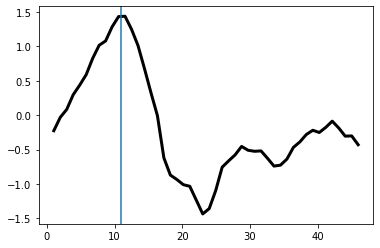

In [33]:
plt.plot(time2, LN_mean, label = 'Mean', c = 'k', linewidth=3)
plt.axvline(11)

### Adding the 1000 m isobath to the maps

In [34]:
%%time
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=False)[0:500,:].load() # remove all values bigger than 1000
# Wall time: 94.4 ms

CPU times: user 204 ms, sys: 37.3 ms, total: 241 ms
Wall time: 609 ms


### Plotting routine interannual time series + idealised time series & spatial patterns

#### Define functions for the cake plot in panel (a)

In [35]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path
def fancy_plot2(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 30), # longitude grid lines
                  ylocs= np.linspace(0, -90, num=10)) # latitude grid lines
    ax.coastlines(); # add coast lines
    # theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
    xlab =    [   .92,     .06,   -.01,    .15,     .3,     .36,    .68]#,     .41] # x-position of labels
    ylab =    [   .73,     .74,    .25,    .05,   -.08,    1.01,      1]#,     .05] # y-position of labels
    txt_lab = ['60°W', '150°W', '60°S', '70°S', '80°S', '120°W', '90°W']#, '150°W'] # label text
    # loop through the 7 label and surround with white space for higher visibility
    for l in range(len(xlab)):
        ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

CPU times: user 41 µs, sys: 7 µs, total: 48 µs
Wall time: 67.5 µs


CPU times: user 12.7 s, sys: 2.01 s, total: 14.7 s
Wall time: 12.2 s


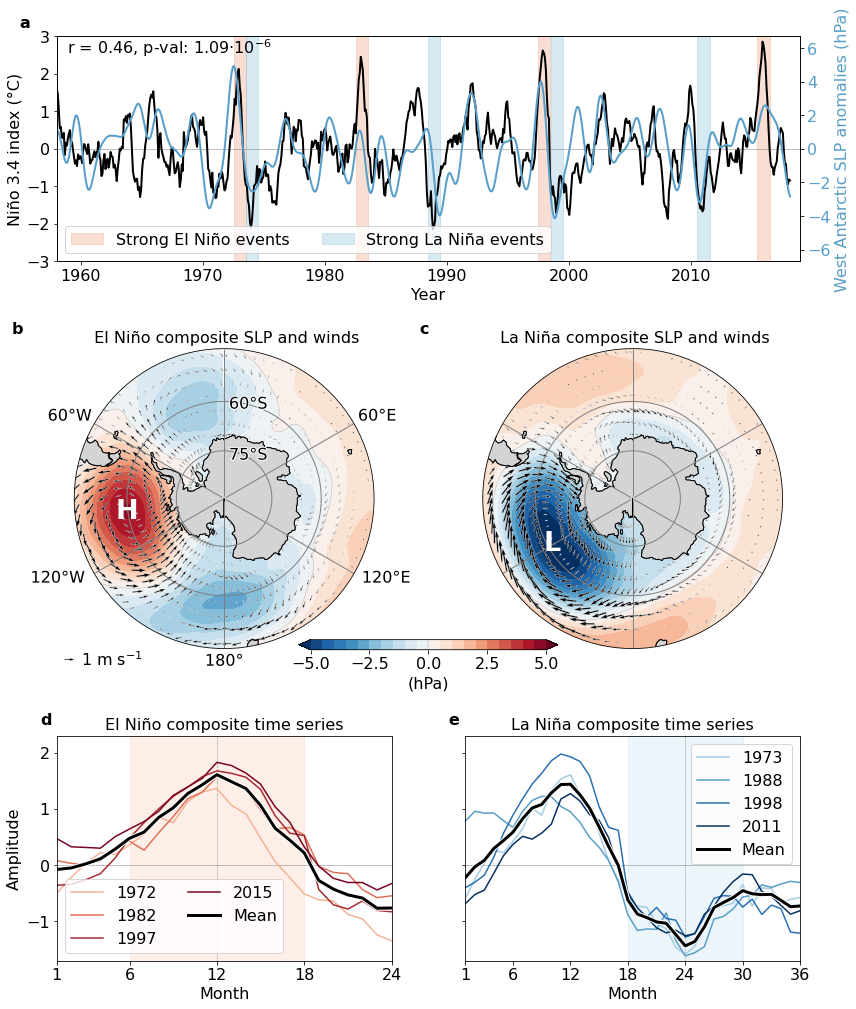

In [38]:
%%time
filename= 'Composite_N34_PC2_time_series_JRA_all_panels'
stand = 0
time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,48,48) # time axis of idealised time series
time3 = np.linspace(1958,2018,722)
time_N34 = pd.date_range(start='1958-01-16', end='2018-02-01', periods=len(N34_JRA))
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(12,14),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[.75,1,.75]) 
event = ['El Niño', 'La Niña']
       
# ---------------------------- subplot 1 ---------------------------- #
for f in [0, 1, 2, 3, 4, 5]:
    if f == 0:
        ax1 = plt.subplot(gs[0,:])
        plt.axhline(0, linewidth=.5, c='grey')
        
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #
        plt.plot(time_N34, N34_JRA, linewidth=2, c='k')
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #

        # h1 = plt.plot(time3, N34_JRA, c = 'k')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        plt.xlabel('Year', fontsize=16); ax1.set_ylabel('Niño 3.4 index (°C)', fontsize=16)  # we already handled the x-label with ax1 

        plt.ylim([-3,3])

        
        # colour the periods of strong EN & LN
        EN_periods = [168,192,288,312,467,491,683,707]; LN_periods = [168,216,347,395,468,516,612,660]
        # first doing the shading manually so that I can have figure labels
        ax1.axvspan(time_N34[EN_periods[0]+6], time_N34[EN_periods[0]+18], color=rotblau[6], alpha=.3, label='Strong El Niño events')
        ax1.axvspan(time_N34[LN_periods[0]+6+12], time_N34[LN_periods[0]+18+12], color=rotblau[14], alpha=.3, label='Strong La Niña events')
        for f in [2,4,6]:
            ax1.axvspan(time_N34[EN_periods[f]+6], time_N34[EN_periods[f]+18], color=rotblau[6], alpha=.3)
            ax1.axvspan(time_N34[LN_periods[f]+6+12], time_N34[LN_periods[f]+18+12], color=rotblau[14], alpha=.3)
        # plt.plot(time3,  anom_cy4-10,           linewidth=2, c = [.83,.83,.83], label='Original West Antarctica') # to get the legend item, plot the time series but with an y-offset
                                                                                                                              # this way, the time series does not show up in the plot but I have the label
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
        # a second y-axis now on the right
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #
        # plt.plot(pd.date_range(start='1959-01-01', end='2018-12-01', periods=len(ASL_SectorPres_11m)), ASL_SectorPres_11m, linewidth=2, c=rotblau[15])
        plt.plot(pd.date_range(start='1958-01-16', end='2018-02-01', periods=len(filtered)), filtered/100, c=rotblau[15], linewidth=2)
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #

        import datetime
        ax1.set_xlim([datetime.date(1958, 1, 16), datetime.date(2018, 12, 1)])
        # plt.xlim([1958,2018]); #plt.ylim([980,1010])

#         plt.title('Tropical and West Antarctic shelf temperature anomalies', fontsize=16)
        plt.ylabel(None); 
        ax2.tick_params(axis='y', labelcolor=rotblau[15]); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

        # adding legend
        # h, l = ax1.get_legend_handles_labels() # Extracting handles and labels
        # ph = [plt.plot([],marker="", ls="")[0]] # Canvas
        # handles = ph + h
        # labels = ['Strong events:'] + l  # Merging labels
        # plt.legend(handles, labels, ncol=3, fontsize=16)

        ax1.legend(fontsize=16, ncol=5, bbox_to_anchor=(.0, 0), loc='lower left')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        
        # plt.ylabel('Regressed West Antarctica (°C)', color=rotblau[3], fontsize=16)
        # ax2.text(2021, 0, '\n Original West Antarctica (°C)', color=rotblau[17], fontsize=16, rotation='vertical', va='center', alpha=.6)
        plt.ylabel('West Antarctic SLP anomalies (hPa)', color=rotblau[15], fontsize=16)
        ax1.text(-.05, 1.04, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top        
             
        plt.text(time_N34[10], 5.7, 'r = '+str(np.round(cor.values, 2))+', p-val: '+ str(np.round(pval.values*1e6, 2)) + '$\cdot10^{-6}$', fontsize=16)
        plt.ylim([-6.7,6.7])        

    if f == 1:
        ax1 = plt.subplot(gs[2,0]); plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time, N34_1972, color=rotblau[7], label='1972')
        plt.plot(time, N34_1982, color=rotblau[5], label='1982')
        plt.plot(time, N34_1997, color=rotblau[3], label='1997')
        plt.plot(time, N34_2015, color=rotblau[1], label='2015')
    if f == 2:
        ax1 = plt.subplot(gs[2,1]); plt.axvline(24, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time2, N34_1973, color=rotblau[13], label='1973')
        plt.plot(time2, N34_1988, color=rotblau[15], label='1988')
        plt.plot(time2, N34_1998, color=rotblau[17], label='1998')
        plt.plot(time2, N34_2011, color=rotblau[20], label='2011')
        
    EN_mean = np.zeros(24); LN_mean = np.zeros(24+24)
    for i in range(24):
        EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
    for i in range(24+24):
        LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
    
    if f == 1:
        plt.plot(time, EN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time, EN_mean, label = 'Mean', c = 'k', linewidth=3)
        # h.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        # poly1 = np.poly1d(np.polyfit(time, EN_mean,4))
        # N34_JRA_poly = poly1(time) # new time series constructed from the polynomial
        # plt.plot(time, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[17])
        ax1.axvspan(time[5], time[17], color=rotblau[8], alpha=.3) # shade period July to June the following year
        plt.title(event[0]+ ' composite time series', fontsize=16); ax1.set_xlabel('Month', fontsize=16)
        ax1.text(-.05, 1.05, string.ascii_lowercase[3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
    if f == 2:
        plt.plot(time2, LN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time2, LN_mean, label = 'Mean', c = 'k', linewidth=3)
        # poly2 = np.poly1d(np.polyfit(time2, LN_mean,4))
        # N34_JRA_poly = poly2(time2) # new time series constructed from the polynomial
        # plt.plot(time2, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[3])
        ax1.axvspan(time2[5+12], time2[17+12], color=rotblau[12], alpha=.3)
        plt.title(event[1]+ ' composite time series', fontsize=16); ax1.set_xlabel('Month', fontsize=16)
        ax1.text(-.05, 1.05, string.ascii_lowercase[4], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=1)
    if f in [1,2]:    
        ax1.set_ylabel('Amplitude', fontsize=16)
        # set fontsizes and labels
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        # if f == 0: ax1.set_xticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
        plt.ylim([-1.7,2.3]); plt.locator_params(axis='y', nbins=4) # only 3 y-axis ticks
    if f == 1: plt.xlim([1,24]); ax1.set_xticks([1, 6, 12, 18, 24]) # adjust limit, custom x-ticks 
    if f == 2: plt.xlim([1,36]); ax1.set_xticks([1, 6, 12, 18, 24, 30, 36]); ax1.set_yticklabels([]); ax1.set(ylabel=None) # no x axis ticks and labels
    
    base = '/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/'
    if f in [3,4]:
        skala = 30; niveau = [-12,-10,-8,-6,-4,-2,2,4,6,8,10,12]
        if f in [3]:
            panel = gs[1,0]; 
            map = xr.open_dataset(base+'sp_mean_anoms_EN.nc').psl/100
            titel = ' \n El Niño composite SLP and winds'; ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').vas_10m 
        if f in [4]:
            titel = ' \n La Niña composite SLP and winds'; ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            panel = gs[1,1]; map = xr.open_dataset(base+'sp_mean_anoms_LN.nc').psl/100
            ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').vas_10m; 
            
        ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
        ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
        
        # --------------------------------------------------------------------------------------------------------------------------- #
        p1 = map.plot.contourf(ax=ax1, levels=ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p111 = map.plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
        # p1000 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        # --------------------------------------------------------------------------------------------------------------------------- #

        # plot markers of maximum anomaly amplitude
        # max lon EN,   max lat EN, max lon LN,   max lat LN
        peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
        if f == 3: 
            # peak_anom_coords = slp_anom.where(slp_anom == slp_anom.max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude
            
            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs -> '\N{PLUS SIGN}' or '\N{MINUS SIGN}'
            txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], 'H', c='w', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center'); ascii_nr = 1 # horizontally and vertically aligned marker
            
        if f == 4:
            txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], 'L', c='w', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center'); ascii_nr = 2

  
        ax1.text(-.21, 1.05, string.ascii_lowercase[ascii_nr], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
       
        fancy_plot(ax1)
        if f in [3]:
            xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .58,    .58] # x-position of labels
            ylab =    [   .76,     .22,  -.057,     .22,    .76,    .63,    .80] # y-position of labels
            txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S']

    
    
            # loop through the 7 labels and surround with white space for higher visibility
            for l in range(len(txt_lab)):
                ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                        fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

                

        if f in [3,4]:
            # adding 10 m wind data
            # specifics for the wind speed arrows
            X = uas_10m.lon; Y = uas_10m.lat
            U = uas_10m; V = vas_10m
            # widths = np.linspace(-.0001, .0001, X.size)
            # Add the wind stress arrows, only plotting every 30th data point.
            # --------------------------------------------------------------------------------------------------------------------------- #
            Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), 
                       to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
                       scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w')) 
                                  # minshaft = select minimum sized arrow (i.e., only those larger than 2)
            # --------------------------------------------------------------------------------------------------------------------------- #

            # reference key on the map
                                # x0,   y0, scale
        if f == 3:
            qk = plt.quiverkey(Q, 0, -.035, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 

        if f in [3,4]:
            plt.title(titel, fontsize=16) # add title
            
        if f in [4]: # add colour bar 
            cax = fig.add_axes([.35, .36, .3, .01]) # x0, y0, width, height
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
            cb.set_label(label=clabel, size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111)            
        
# --- saving as 300 dpi .PNG image in specified folder ------------------------------------- #
plt.savefig(save + filename+'_slp_winds_only_and_added_time_series_bigger_maps', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                          #
            format=None, transparent=False, bbox_inches='tight',                             #
            pad_inches=0.1, metadata=None)                                                   #
# --- end of script ------------------------------------------------------------------------ # 
# Wall time: 8.32 s

### Old layout with maps vertical

NameError: name 'ASL_JRA_11m' is not defined

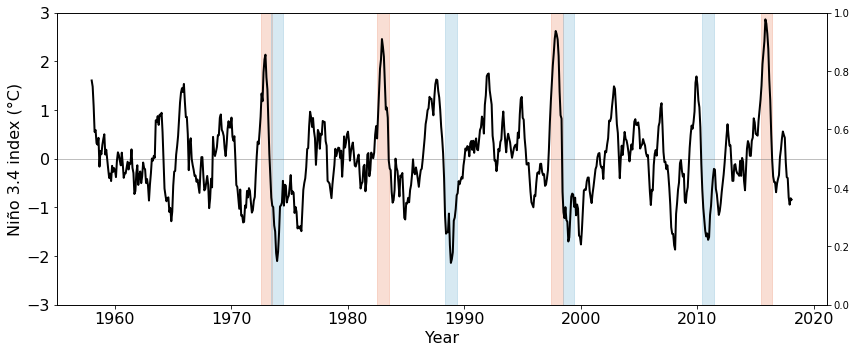

In [37]:
%%time
filename= 'Composite_N34_PC2_time_series_JRA_all_panels'
stand = 0
time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,48,48) # time axis of idealised time series
time3 = np.linspace(1958,2018,722)
time_N34 = pd.date_range(start='1958-01-16', end='2018-02-01', periods=len(N34_JRA))
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(12,14),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1.1], height_ratios=[1,1,1]) 
event = ['El Niño', 'La Niña']
       
# ---------------------------- subplot 1 ---------------------------- #
for f in [0, 1, 2, 3, 4, 5]:
    if f == 0:
        ax1 = plt.subplot(gs[0,:])
        plt.axhline(0, linewidth=.5, c='grey')
        
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #
        plt.plot(time_N34, N34_JRA, linewidth=2, c='k')
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #

        # h1 = plt.plot(time3, N34_JRA, c = 'k')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        plt.xlabel('Year', fontsize=16); ax1.set_ylabel('Niño 3.4 index (°C)', fontsize=16)  # we already handled the x-label with ax1 

        plt.ylim([-3,3])

        
        # colour the periods of strong EN & LN
        EN_periods = [168,192,288,312,467,491,683,707]; LN_periods = [168,216,347,395,468,516,612,660]
        # first doing the shading manually so that I can have figure labels
        ax1.axvspan(time_N34[EN_periods[0]+6], time_N34[EN_periods[0]+18], color=rotblau[6], alpha=.3, label='Strong El Niño events')
        ax1.axvspan(time_N34[LN_periods[0]+6+11], time_N34[LN_periods[0]+18+11], color=rotblau[14], alpha=.3, label='Strong La Niña events')
        for f in [2,4,6]:
            ax1.axvspan(time_N34[EN_periods[f]+6], time_N34[EN_periods[f]+18], color=rotblau[6], alpha=.3)
            ax1.axvspan(time_N34[LN_periods[f]+6+11], time_N34[LN_periods[f]+18+11], color=rotblau[14], alpha=.3)
        # plt.plot(time3,  anom_cy4-10,           linewidth=2, c = [.83,.83,.83], label='Original West Antarctica') # to get the legend item, plot the time series but with an y-offset
                                                                                                                              # this way, the time series does not show up in the plot but I have the label
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
        # a second y-axis now on the right
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
        # h2 = plt.plot(time,  anom_cy4*N34_JRA, linewidth=2, c = rotblau[3], label = 'Cycle 4')
        # h2 = plt.plot(time3,  anom_cy4,           linewidth=2, c = rotblau[15]) # anom regressed is the same as anom_cy4*N34_JRA
        # h2 = plt.plot(time3,  anom_cy4_regressed, linewidth=2, c = rotblau[3], label = 'Cycle 4') # anom regressed is the same as anom_cy4*N34_JRA

        # h2 = plt.plot(np.linspace(1959,2018,len(ASL_SectorPres_5m)), ASL_SectorPres_5m,
        #               linewidth=2, c = rotblau[15]) # 11-month rolling window ASL sector pressure
                
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #
        # plt.plot(pd.date_range(start='1959-01-01', end='2018-12-01', periods=len(ASL_SectorPres_11m)), ASL_SectorPres_11m, linewidth=2, c=rotblau[15])
        plt.plot(pd.date_range(start='1958-01-16', end='2018-02-01', periods=len(ASL_JRA_11m)), ASL_JRA_11m/100, c=rotblau[15], linewidth=2)
        # ------------------------------------------------------------------------------------------------------------------------------------------------------ #

        import datetime
        ax1.set_xlim([datetime.date(1958, 1, 16), datetime.date(2018, 12, 1)])
        # plt.xlim([1958,2018]); #plt.ylim([980,1010])

#         plt.title('Tropical and West Antarctic shelf temperature anomalies', fontsize=16)
        plt.ylabel(None); 
        ax2.tick_params(axis='y', labelcolor=rotblau[15]); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

        # adding legend
        # h, l = ax1.get_legend_handles_labels() # Extracting handles and labels
        # ph = [plt.plot([],marker="", ls="")[0]] # Canvas
        # handles = ph + h
        # labels = ['Strong events:'] + l  # Merging labels
        # plt.legend(handles, labels, ncol=3, fontsize=16)

        ax1.legend(fontsize=16, ncol=5, bbox_to_anchor=(.0, 0), loc='lower left')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        
        # plt.ylabel('Regressed West Antarctica (°C)', color=rotblau[3], fontsize=16)
        # ax2.text(2021, 0, '\n Original West Antarctica (°C)', color=rotblau[17], fontsize=16, rotation='vertical', va='center', alpha=.6)
        plt.ylabel('West Antarctic SLP anomalies (hPa)', color=rotblau[15], fontsize=16)
        ax1.text(-.05, 1.04, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top        
             
        plt.text(time_N34[10], 5.7, 'r = '+str(corr2), fontsize=16)
        plt.ylim([-6.7,6.7])
        
        

#     # plot with ENSO subsurface temperature anomalies regression map
#     if f == 5:
#         skala = 30; niveau = [-12,-10,-8,-6,-4,-2,2,4,6,8,10,12]
#         if f in [5]:
#             panel = gs[0,0]
#             midlon = -105 # specifics for the plot extent
#             maxlon = midlon + 65
#             minlon = midlon - 65
#             minlat = -80
#             maxlat = -60
#             midlat = (minlat + maxlat)/2
#             ticks = np.linspace(-.5,.5,21)
#             ticks_depth_lat = np.linspace(-.5,.5,21)
        
#             map = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_regression_map_N34_WAtemp.nc').temp
#             titel = 'Idealised spatial patterns\n\n El Niño sea level pressure and surface winds'; ticks = np.linspace(-.2,.2,21); clabel = '(hPa)'
       
#         ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
#         ax1.coastlines(resolution='50m')
#         lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
#         lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

#         ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

#         boundary_path = make_boundary_path(lons, lats)
#         ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

#         # ----------------------------------------------------------------------------------------------------------------------------------------- #
#         p2   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
#         p22  = map.plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
#         # 1000 dbar isobath
#         p222 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
#         # ----------------------------------------------------------------------------------------------------------------------------------------- #
        
#         fancy_plot2(ax1); plt.title('Niño 3.4 regression pattern \n', fontsize=16)               
#         if f in [5]: # add colour bar 
#             cax = fig.add_axes([.071, .71, .3, .01]) # x0, y0, width, height
#             cb = plt.colorbar(p2, cax = cax, shrink=.5, orientation='horizontal'); 
#             cb.set_label(label='(°C)', size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
#             cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p222)
#         ax1.text(-.044, 1.41, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
 

    if f == 1:
        ax1 = plt.subplot(gs[1,1]); plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time, N34_1972, color=rotblau[7], label='1972')
        plt.plot(time, N34_1982, color=rotblau[5], label='1982')
        plt.plot(time, N34_1997, color=rotblau[3], label='1997')
        plt.plot(time, N34_2015, color=rotblau[1], label='2015')
    if f == 2:
        ax1 = plt.subplot(gs[2,1]); plt.axvline(24, linestyle = '--', c = 'grey', linewidth=.5)
        plt.axhline(0, c = 'grey', linewidth=.5)
        plt.plot(time2, N34_1973, color=rotblau[13], label='1973')
        plt.plot(time2, N34_1988, color=rotblau[15], label='1988')
        plt.plot(time2, N34_1998, color=rotblau[17], label='1998')
        plt.plot(time2, N34_2011, color=rotblau[20], label='2011')
        
    EN_mean = np.zeros(24); LN_mean = np.zeros(24+24)
    for i in range(24):
        EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
    for i in range(24+24):
        LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
    
    if f == 1:
        plt.plot(time, EN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time, EN_mean, label = 'Mean', c = 'k', linewidth=3)
        # h.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        # poly1 = np.poly1d(np.polyfit(time, EN_mean,4))
        # N34_JRA_poly = poly1(time) # new time series constructed from the polynomial
        # plt.plot(time, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[17])
        ax1.axvspan(time[5], time[17], color=rotblau[8], alpha=.3) # shade period July to June the following year
        plt.title(event[0]+ ' composite time series', fontsize=16); ax1.set_xlabel('Month', fontsize=16)
        ax1.text(-.05, 1.05, string.ascii_lowercase[2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
    if f == 2:
        plt.plot(time2, LN_mean, c = 'w', linewidth=5) # white edgecolor
        plt.plot(time2, LN_mean, label = 'Mean', c = 'k', linewidth=3)
        # poly2 = np.poly1d(np.polyfit(time2, LN_mean,4))
        # N34_JRA_poly = poly2(time2) # new time series constructed from the polynomial
        # plt.plot(time2, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[3])
        ax1.axvspan(time2[5+12], time2[17+12], color=rotblau[12], alpha=.3)
        plt.title(event[1]+ ' composite time series', fontsize=16); ax1.set_xlabel('Month', fontsize=16)
        ax1.text(-.05, 1.05, string.ascii_lowercase[4], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.legend(fontsize=16, ncol=2)
    if f in [1,2]:    
        ax1.set_ylabel('Amplitude', fontsize=16)
        # set fontsizes and labels
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        # if f == 0: ax1.set_xticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
        plt.ylim([-1.7,2.3]); plt.locator_params(axis='y', nbins=4) # only 3 y-axis ticks
    if f == 1: plt.xlim([1,24]); ax1.set_xticks([1, 6, 12, 18, 24]) # adjust limit, custom x-ticks 
    if f == 2: plt.xlim([1,36]); ax1.set_xticks([1, 6, 12, 18, 24, 30, 36])

    base = '/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/'
    if f in [3,4]:
        skala = 30; niveau = [-12,-10,-8,-6,-4,-2,2,4,6,8,10,12]
        if f in [3]:
            panel = gs[1,0]; 
            map = xr.open_dataset(base+'sp_mean_anoms_EN.nc').psl/100
            titel = ' \n El Niño composite SLP and winds'; ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_EN.nc').vas_10m 
        if f in [4]:
            titel = ' \n La Niña composite SLP and winds'; ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            panel = gs[2,0]; map = xr.open_dataset(base+'sp_mean_anoms_LN.nc').psl/100
            ticks = np.linspace(-5,5,21); clabel = '(hPa)'
            uas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').uas_10m
            vas_10m = xr.open_dataset(base+'sp_mean_anoms_LN.nc').vas_10m; 
            
        ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
        ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
        
        # --------------------------------------------------------------------------------------------------------------------------- #
        p1 = map.plot.contourf(ax=ax1, levels=ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p111 = map.plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
        # --------------------------------------------------------------------------------------------------------------------------- #

        # plot markers of maximum anomaly amplitude
        # max lon EN,   max lat EN, max lon LN,   max lat LN
        peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
        if f == 3: 
            # peak_anom_coords = slp_anom.where(slp_anom == slp_anom.max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude
            
            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs -> '\N{PLUS SIGN}' or '\N{MINUS SIGN}'
            txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], 'H', c='w', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center'); ascii_nr = 1 # horizontally and vertically aligned marker
            
        if f == 4:
            txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], 'L', c='w', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center'); ascii_nr = 3

  
        ax1.text(-.21, 1.05, string.ascii_lowercase[ascii_nr], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
       
        fancy_plot(ax1)
        if f in [3]:
            xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .58,    .58] # x-position of labels
            ylab =    [   .76,     .22,  -.057,     .22,    .76,    .63,    .80] # y-position of labels
            txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S']

    
    
            # loop through the 7 labels and surround with white space for higher visibility
            for l in range(len(txt_lab)):
                ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                        fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

        if f in [3,4]:
            # adding 10 m wind data
            # specifics for the wind speed arrows
            X = uas_10m.lon; Y = uas_10m.lat
            U = uas_10m; V = vas_10m
            # widths = np.linspace(-.0001, .0001, X.size)
            # Add the wind stress arrows, only plotting every 30th data point.
            Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), 
                       to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
                       scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w')) 
                                  # minshaft = select minimum sized arrow (i.e., only those larger than 2)
            # reference key on the map
                                # x0,   y0, scale
        if f == 3:
            qk = plt.quiverkey(Q, .75, -.035, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 

        # if f in [3,5]:
        #     p11 = rlds.plot.contour(levels = niveau, linewidths=2, cmap=cm.cm.phase, transform=ccrs.PlateCarree())
        #     ax1.clabel(
        #             p11,  # Typically best results when labelling line contours.
        #             colors=['black'], fontsize=16,
        #             manual=False,  # Automatic placement vs manual placement.
        #             inline=True,  # Cut the line where the label will be placed.
        #             fmt=' {:.0f} '.format)  # Labes as integers, with some extra space.

        if f in [3,4]:
            plt.title(titel, fontsize=16) # add title
            
        # if f in [3]: # add colour bar 
        #     cax = fig.add_axes([.411, .0631, .24125, .012]) # position: [x0, y0, width, height]
        #     cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
        #     cb.set_label(label=clabel, size=16)
        #     cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
        #     cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111) # add contours to colour bar
        if f in [4]: # add colour bar 
            cax = fig.add_axes([.106, .03, .3, .01]) # x0, y0, width, height
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
            cb.set_label(label=clabel, size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111)            
            
# --- saving as 300 dpi .PNG image in specified folder ------------------------------------- #
plt.savefig(save + filename+'_slp_winds_only_and_added_time_series', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                          #
            format=None, transparent=False, bbox_inches='tight',                             #
            pad_inches=0.1, metadata=None)                                                   #
# --- end of script ------------------------------------------------------------------------ # 
# Wall time: 8.32 s

# For ACCESS-OM2-01

### First saving the anomalous spatial patterns as .nc files
script based on the one from Ryan in 
/home/561/rmh561/access-om2/1deg_jra55v14_ryf_rcpWCWCpactest/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

and the one from Matt on github
https://github.com/mpudig/1deg_jra55_ryf/blob/v14_rcp_sinusoid_x1_period7/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

In [10]:
%%time

# first delete the files if they already exist as otherwise the script runs into problems --- #
os.system('rm -r /g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_*')
os.system('rm -r /g/data/e14/mv7494/ENSOAnt_input/time_series/ts_mean_anoms_*')
# ------------------------------------------------------------------------------------------- #

# define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 2550 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

JRAout = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/' # Output location for storing scaling files created by this script
var  = ['q_10',     'slp', 't_10',    'u_10',    'v_10',    'rain', 'snow', 'rlds', 'rsds', 'runoff_all'] # input variables for ACCESS-OM2
var2 = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for JRA55-do-1-3
var3 = ['huss',     'psl', 'tas',     'uas',     'vas',     'prra', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for monthly JRA55-do-1-3 files

for n in range(2): # loop through the different simulations
    if n == 0: suffix = 'mean_anoms_EN'; periode = EN_periods; tend = 2551 # end year of window in which scaling will be applied
    if n == 1: suffix = 'mean_anoms_LN'; periode = LN_periods; tend = 2553 # end year of window in which scaling will be applied

    print('Creating time series and anomalous maps for '+suffix+':')
    print('----------------------------------------------------------')

    for i in range(len(var)): # loop through all variables except taux and tauy
        # get the JRA55-do for the file structure
        if var[i] in ['q_10','slp','t_10','u_10','v_10']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; length_year = 2920;
        if var[i] in ['rain','snow','rlds','rsds']:       domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
        if var[i] in ['runoff_all']:                      domain = 'land/day/';    timestep = ['0101','1231'];         length_year = 365;
        print(domain+var[i])
        
        JRA_field = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var[i]+'.1990_1991.nc') 
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Creating time series files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        # Extract time series and structure from original files:
        timeRYF = JRA_field[var2[i]].time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate Nino3.4 time series to correct temporal resolution of input file
        if n == 0:      # np.interp(              target length           ,            original length              , original data)
            time_series = np.interp(np.linspace(1,24,len((timeYR-zeroYR))), np.linspace(0,len(EN_mean),len(EN_mean)), EN_mean)

# # create a step function for testing ----- #
#             time_series[0:8*31] = 0
#             time_series[8*31:8*31+8*28] = 50
#             time_series[8*31+8*28:] = 0
# # ---------------------------------------- #

        if n == 1: 
            time_series = np.interp(np.linspace(1,48,len((timeYR-zeroYR))), np.linspace(0,len(LN_mean),len(LN_mean)), LN_mean)
            
                
        # Create new Datasets:
        ds = xr.DataArray(time_series, dims=['time'], coords={'time': timeFULL}, attrs=JRA_field[var2[i]].attrs)
        DS_out = JRA_field.drop_vars(var2[i]).assign_coords({'time':timeFULL}) 
        DS_out[var2[i]] = ds
        DS_out.attrs.update({'title': 'Scaling for ' + DS_out.attrs['title']})
        DS_out.time.attrs.update(JRA_field.time.attrs) # get the right attribute from the JRA file
        DS_out.time.encoding['units'] = "days since '1900-01-01'" 
#         double time(time) ;
#                 time:_FillValue = NaN ;
#                 time:cartesian_axis = "T" ;
#                 time:modulo = " " ;
#                 time:axis = "T" ;
#                 time:units = "days since 1900-01-01" ;
#                 time:calendar = "noleap" ;

        if i == 0: ts_huss_10m = DS_out.huss_10m
        if i == 1: ts_psl      = DS_out.psl
        if i == 2: ts_tas_10m  = DS_out.tas_10m
        if i == 3: ts_uas_10m  = DS_out.uas_10m
        if i == 4: ts_vas_10m  = DS_out.vas_10m
        if i == 5: ts_prrn     = DS_out.prrn
        if i == 6: ts_prsn     = DS_out.prsn
        if i == 7: ts_rlds     = DS_out.rlds
        if i == 8: ts_rsds     = DS_out.rsds
        if i == 9: ts_friver   = DS_out.friver               

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Create spatial scaling files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        DS_out = JRA_field.isel(time=0)
        anom = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-'+forcing+'/monthly_anom/'+'JRA55-do-'+forcing+'_'+
                               var3[i]+'_monthly_anom_1958-2018.nc')[var3[i]]

        # index['time'] = field.time # replace N34 time step values with the values from the field

        # calculate the mean anomalies during the four extreme EN periods
        # peak of event is during the 12th month of the event, therefore select 
        # anomalies 6 months prior to 6 months after and take the mean
        if n == 0: # if El Niño event
            DS_out = (anom[periode[0]+6:periode[0]+18,:,:].mean('time') + anom[periode[2]+6:periode[2]+18,:,:].mean('time') + \
                anom[periode[4]+6:periode[4]+18,:,:].mean('time') + anom[periode[6]+6:periode[6]+18,:,:].mean('time'))/4
            DS_out[var2[i]] = DS_out 

        if n == 1: # if La Niña event -> a bit different as the time series is much longer
            DS_out = ((anom[periode[0]+17:periode[0]+28,:,:].mean('time') + anom[periode[2]+17:periode[2]+28,:,:].mean('time') + \
                anom[periode[4]+17:periode[4]+28,:,:].mean('time') + anom[periode[6]+17:periode[6]+28,:,:].mean('time'))/4) * -1
            DS_out[var2[i]] = DS_out 

        if i == 0: huss_10m = DS_out.drop(['height','huss_10m'])
        if i == 1: psl      = DS_out
        if i == 2: tas_10m  = DS_out.drop(['height','tas_10m'])
        if i == 3: uas_10m  = DS_out.drop(['height','uas_10m'])
        if i == 4: vas_10m  = DS_out.drop(['height','vas_10m'])
        if i == 5: prrn     = DS_out.drop(['prrn'])
        if i == 6: prsn     = DS_out.drop(['prsn'])
        if i == 7: rlds     = DS_out.drop(['rlds'])
        if i == 8: rsds     = DS_out.drop(['rsds'])
        if i == 9: friver   = DS_out.drop(['friver'])
    
    # saving the time series back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': ts_huss_10m, 'psl': ts_psl, 'tas_10m': ts_tas_10m,
                      'uas_10m': ts_uas_10m, 'vas_10m': ts_vas_10m,
                      'prrn': ts_prrn, 'prsn': ts_prsn,
                      'rlds': ts_rlds, 'rsds': ts_rsds})
    DS4.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/time_series/ts_'+suffix+'.nc')

    # separate file for friver as it has a resolution of (730)
    ts_friver.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/time_series/ts_'+suffix+'_friver.nc')  
    
    # saving the spatial patterns back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': huss_10m, 'psl': psl, 'tas_10m': tas_10m,
                      'uas_10m': uas_10m, 'vas_10m': vas_10m,
                      'prrn': prrn, 'prsn': prsn,
                      'rlds':rlds, 'rsds': rsds})  
    DS4.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_'+suffix+'.nc')
    friver.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_'+suffix+'_friver.nc')
        
    print('----------------------------------------------------------')
# Wall time: 43.3 s       per variable 
# Wall time: 16min 30s for all variables

rm: cannot remove '/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_*': No such file or directory
rm: cannot remove '/g/data/e14/mv7494/ENSOAnt_input/time_series/ts_mean_anoms_*': No such file or directory


Creating time series and anomalous maps for mean_anoms_EN:
----------------------------------------------------------
atmos/3hrPt/q_10
atmos/3hrPt/slp
atmos/3hrPt/t_10
atmos/3hrPt/u_10
atmos/3hrPt/v_10
atmos/3hr/rain
atmos/3hr/snow
atmos/3hr/rlds
atmos/3hr/rsds
land/day/runoff_all
----------------------------------------------------------
Creating time series and anomalous maps for mean_anoms_LN:
----------------------------------------------------------
atmos/3hrPt/q_10
atmos/3hrPt/slp
atmos/3hrPt/t_10
atmos/3hrPt/u_10
atmos/3hrPt/v_10
atmos/3hr/rain
atmos/3hr/snow
atmos/3hr/rlds
atmos/3hr/rsds
land/day/runoff_all
----------------------------------------------------------
CPU times: user 5.71 s, sys: 1.76 s, total: 7.47 s
Wall time: 10.3 s


### Here the HEAVY-LIFTING: saving the anomalous forcing fields and idealised time series as .nc files

In [11]:
%%time
from scipy.interpolate import interp1d # using scipy here for the interpolation for N34 onto higher resolution
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
var = ['huss','psl','tas', 'uas','vas','prra','prsn','rlds','rsds','friver'] # only eight of the variables I used in my Msc
var2 = ['huss_10m','psl','tas_10m', 'uas_10m','vas_10m','prrn','prsn','rlds','rsds','friver']
var3 = ['q_10','slp','t_10', 'u_10','v_10','rain','snow','rlds','rsds','runoff_all'] # filename name variable on /g/data/ua8 for RYF forcing
  
for e in [1]:#range(2): # loop through the El Niño and La Niña events
    if e == 0: 
        suffix = 'ENFull'; save_folder = 'forcing_mean_anoms_ENFull/'
        print('Creating anomalous forcing fields for '+suffix+', 2-yr EXP:')
        ts = EN_mean # the original time series
    if e == 1: 
        suffix = 'LNFull'; save_folder = 'forcing_mean_anoms_LNFull/'
        print('Creating anomalous forcing fields for '+suffix+', 4-yr EXP:')
        ts = LN_mean # the original time series
    print('----------------------------------------------------------')
    
    for i in range(len(var)): # loop through all variables
        if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['199001010000','199012312230']; length_year = 2920
        if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['199001010130','199101010000']; length_year = 2920
        if var[i] in ['friver']:                            domain = 'ocean/day/';   timestep = ['19900101','19910101'];         length_year = 365
        
        # load in JRA55-do field, RYF field and copy the latter to get the correct .nc file structure
        JRA_field = xr.open_dataset(base+domain+var[i]+'/gn/v20180412/'+
                        var[i]+'_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-'+forcing+'_gn_'+timestep[0]+'-'+timestep[1]+'.nc')[var[i]]
        RYF_field = xr.open_dataset('/g/data/ua8/JRA55-do/RYF/v1-3/'+'RYF.'+var3[i]+'.1990_1991.nc')[var2[i]]
        # RYF_field_final = RYF_field # copy file structure to write the forcing data into it
        RYF_field_final = RYF_field.where(RYF_field > 27, other=0).where(RYF_field < 27, other=0) # copy file structure and fill with only zero values
                                                                                                  # later, I then fill up this array each time step with the forcing data

        if var[i] != 'friver': # special case for the daily runoff field (all other fields are 3-hourly)                  
            pattern = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'.nc')[var2[i]].load()
        else: 
            pattern = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'_friver.nc')[var2[i]].load()
        print(domain+var[i])
        
        # Matt's part from here
        # --------------------------------- part with leap day correction --------------------------------- #
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # Extract time series and structure from original files:
        timeRYF = RYF_field.time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate Nino3.4 time series to correct temporal resolution of input file
        time_series = np.interp(np.linspace(1,len(EN_mean),len((timeYR-zeroYR))), np.linspace(0,len(EN_mean),len(EN_mean)), EN_mean)
        
        if e == 0:          # np.interp(target length: either 2*2920 or 4*2920                        , original length, either 24 or 48 months , original time series)
            N34_JRA_highres = np.interp(np.linspace(1,len(EN_mean),length_year*(int(len(EN_mean)/12))), np.linspace(0,len(EN_mean),len(EN_mean)), EN_mean)  
        if e == 1: 
            N34_JRA_highres = np.interp(np.linspace(1,len(LN_mean),length_year*(int(len(LN_mean)/12))), np.linspace(0,len(LN_mean),len(LN_mean)), LN_mean)
        # ---------------------------------------------------------------------------------------------------- #

#         # --------------------------------- part without leap day correction --------------------------------- #
#         # N34_JRA_highres = poly1(np.linspace(1,25,length_year*2)) # interpolate Nino3.4 polynomial to correct temporal resolution of input file        

#         x_old = np.linspace(0,len(ts),len(ts)) # original x-axis
#         x_new = np.linspace(0,len(ts),length_year*int(len(ts)/12)) # new x-axis -> if El Niño, then 2920*2, if La Niña, then 2920*4

#         f_linear = scipy.interpolate.interp1d(x_old,ts) # interpolation function
#         N34_JRA_highres = f_linear(np.linspace(0,len(ts),length_year*int(len(ts)/12))) # interpolated time series
#         # ---------------------------------------------------------------------------------------------------- #

        for f in [1,2,3,4]: # loop through the number of years
            if f == 1: 
                time_series = N34_JRA_highres[0:length_year] # 0:2920
            if f == 2: 
                time_series = N34_JRA_highres[length_year:(2*length_year)] # 2920:5840
            if f == 3 and e == 0:
                break # for the El Niño simulation, this loop is finished early, i.e., already after two years since it's a short 2-year simulation 
                      # rather than the 4-year La Niña simulation
            if f == 3 and e == 1: # if La Niña, then my time series are four years long, so I need to split the full interpolated time series into four parts
                time_series = N34_JRA_highres[(length_year*2):(3*length_year)] 
            if f == 4 and e == 1:
                time_series = N34_JRA_highres[(length_year*3):(4*length_year)]           
            
            # skip iteration if file already exists
            if os.path.isfile('/g/data/e14/mv7494/ENSOAnt_input/'+save_folder+'yr'+str(f)+'/'+'RYF.'+var2[i]+'.1990_1991.nc') == True:
                print('Year '+str(f)+' file finished: RYF.'+var2[i]+'.1990_1991.nc')
                continue  

            for t in range(length_year):
                # if t % 1000 == 0: print('time step: '+str(t)) # print every 1000th iteration to see how far the loop is ahead
                
                # --- Here the key part: climatological forcing + anomalies (time series[t] * spatial pattern[x,y]) --- #
                RYF_field_final[t,:,:] = RYF_field[t,:,:] + (pattern.values*time_series[t])                             #
                # JRA_field_input[t,:,:] = pattern.values # for testing                                                 #
                # ----------------------------------------------------------------------------------------------------- #
         
            RYF_field_final.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/'+save_folder+'yr'+str(f)+'/'+
                                      'RYF.'+var2[i]+'.1990_1991.nc')
            print('Year '+str(f)+' file finished: RYF.'+var2[i]+'.1990_1991.nc')
        print('--- --- --- --- ---')
# Wall time: 13 s                    for one variable and both experiments
# Wall time: 3min 9s                 for all variables and one experiment
# Wall time: 11min 23s               for all variables and both El Niño (2-year) and La Niña (4-year simulation)

Creating anomalous forcing fields for LNFull, 4-yr EXP:
----------------------------------------------------------
atmos/3hrPt/huss
Year 1 file finished: RYF.huss_10m.1990_1991.nc
Year 2 file finished: RYF.huss_10m.1990_1991.nc
Year 3 file finished: RYF.huss_10m.1990_1991.nc
Year 4 file finished: RYF.huss_10m.1990_1991.nc
--- --- --- --- ---
atmos/3hrPt/psl
Year 1 file finished: RYF.psl.1990_1991.nc
Year 2 file finished: RYF.psl.1990_1991.nc
Year 3 file finished: RYF.psl.1990_1991.nc
Year 4 file finished: RYF.psl.1990_1991.nc
--- --- --- --- ---
atmos/3hrPt/tas
Year 1 file finished: RYF.tas_10m.1990_1991.nc
Year 2 file finished: RYF.tas_10m.1990_1991.nc
Year 3 file finished: RYF.tas_10m.1990_1991.nc
Year 4 file finished: RYF.tas_10m.1990_1991.nc
--- --- --- --- ---
atmos/3hrPt/uas
Year 1 file finished: RYF.uas_10m.1990_1991.nc
Year 2 file finished: RYF.uas_10m.1990_1991.nc
Year 3 file finished: RYF.uas_10m.1990_1991.nc
Year 4 file finished: RYF.uas_10m.1990_1991.nc
--- --- --- --- ---


In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #